# 1. Data Download 

In [5]:
# ============== Cell 1 — Setup ==============
import os, io, json, gzip, logging
import requests
import pandas as pd
from tqdm import tqdm
from requests.adapters import HTTPAdapter, Retry
import time

PROJECT_ID = "TCGA-BRCA"
DATA_DIR   = "./data/raw"
os.makedirs(DATA_DIR, exist_ok=True)

BASE_URL = "https://api.gdc.cancer.gov"

logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.INFO
)

sess = requests.Session()
retries = Retry(
    total=3, backoff_factor=0.4,
    status_forcelist=(429, 500, 502, 503, 504),
    allowed_methods=("GET",)
)
sess.mount("https://", HTTPAdapter(max_retries=retries))
sess.headers.update({"Accept":"application/json"})

def get_json(path, params):
    r = sess.get(f"{BASE_URL}{path}", params=params, timeout=60)
    r.raise_for_status()
    return r.json()

def download_binary(file_id):
    r = sess.get(f"{BASE_URL}/data/{file_id}", stream=True, timeout=180)
    r.raise_for_status()
    buf = io.BytesIO()
    for ch in r.iter_content(1<<16):
        if ch: buf.write(ch)
    return buf.getvalue()

def read_tsv_infer(raw_bytes):
    try:
        with gzip.GzipFile(fileobj=io.BytesIO(raw_bytes)) as gz:
            return pd.read_csv(gz, sep="\t", comment="#")
    except OSError:
        return pd.read_csv(io.BytesIO(raw_bytes), sep="\t", comment="#")

In [19]:
# ============== Cell 2 — Clinical ==============
logging.info("Downloading clinical (cases + demographics + a diagnosis row) ...")

filters = {"op":"in","content":{"field":"cases.project.project_id","value":[PROJECT_ID]}}
params  = {
    "filters": json.dumps(filters),
    "expand": "diagnoses,demographic,samples",
    "format": "JSON", "size":"4000"
}
js = get_json("/cases", params)

rows = []
for case in js.get("data",{}).get("hits",[]):
    d0 = (case.get("diagnoses") or [dict()])[0]
    rows.append({
        "case_submitter_id": case.get("submitter_id"),
        "demo_gender": (case.get("demographic") or {}).get("gender"),
        "demo_age_at_index_years": (case.get("demographic") or {}).get("age_at_index"),
        "diag_tumor_stage": d0.get("tumor_stage"),
        "sample_types_present": ";".join(
            sorted({
                st for st in ((s or {}).get("sample_type") for s in (case.get("samples") or []))
                if st
            })
        )
    })
clinical_df = pd.DataFrame(rows)
clinical_df.to_csv(os.path.join(DATA_DIR, "clinical_data.csv"), index=False)
clinical_df.head(3)

2025-11-29 12:03:08,531 [INFO] Downloading clinical (cases + demographics + a diagnosis row) ...


,case_submitter_id,demo_gender,demo_age_at_index_years,diag_tumor_stage,sample_types_present
0,TCGA-E2-A107,female,54.0,None,Blood Derived Normal;Primary Tumor
1,TCGA-AC-A62X,female,72.0,None,Blood Derived Normal;Primary Tumor
2,TCGA-E2-A156,female,61.0,None,Blood Derived Normal;Primary Tumor


In [21]:
# ============================ RNA-seq only ============================

# 1) Discover available RNA-seq workflows for TCGA-BRCA (Primary Tumor)
logging.info("Discovering RNA-seq workflows ...")
facet_filters = {
    "op": "and",
    "content": [
        {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT_ID]}},
        {"op": "in", "content": {"field": "files.data_category", "value": ["Transcriptome Profiling"]}},
        {"op": "in", "content": {"field": "files.data_type", "value": ["Gene Expression Quantification"]}},
        {"op": "in", "content": {"field": "cases.samples.sample_type", "value": ["Primary Tumor"]}}
    ]
}
facet_params = {"filters": json.dumps(facet_filters),
                "facets": "analysis.workflow_type", "format": "JSON", "size": "0"}
facet_js = get_json("/files", facet_params)
buckets = (facet_js.get("data", {}).get("aggregations", {})
           .get("analysis.workflow_type", {}).get("buckets", []))
wf_df = pd.DataFrame(buckets).rename(columns={"key": "workflow_type", "doc_count": "count"})
available_wf = wf_df.sort_values("count", ascending=False)["workflow_type"].tolist() if not wf_df.empty else []
logging.info("Available RNA-seq workflows: %s", ", ".join(available_wf) if available_wf else "None")

# 2) Pick best available workflow (normalized preferred)
WF_PREF = ["HTSeq - FPKM-UQ", "HTSeq - FPKM", "HTSeq - Counts", "STAR - Counts"]
wf_try = [wf for wf in WF_PREF if wf in available_wf] + [wf for wf in available_wf if wf not in WF_PREF]
wf_try = list(dict.fromkeys(wf_try))
if not wf_try:
    raise RuntimeError("No RNA-seq workflows found for TCGA-BRCA with current filters.")

def query_rnaseq_files(project_id, workflow_type, size=2000):
    filt = {"op":"and","content":[
        {"op":"in","content":{"field":"cases.project.project_id","value":[project_id]}},
        {"op":"in","content":{"field":"files.data_category","value":["Transcriptome Profiling"]}},
        {"op":"in","content":{"field":"files.data_type","value":["Gene Expression Quantification"]}},
        {"op":"in","content":{"field":"files.analysis.workflow_type","value":[workflow_type]}},
        {"op":"in","content":{"field":"cases.samples.sample_type","value":["Primary Tumor"]}}
    ]}
    fields = [
        "file_id","file_name","cases.submitter_id",
        "cases.samples.submitter_id","cases.samples.sample_type"
    ]
    params = {"filters": json.dumps(filt), "fields": ",".join(fields),
              "format": "JSON", "size": str(size)}
    js = get_json("/files", params)
    return js.get("data", {}).get("hits", [])

hits, chosen_wf = [], None
for wf in wf_try:
    hits = query_rnaseq_files(PROJECT_ID, wf, size=2000)
    if hits:
        chosen_wf = wf
        logging.info("Using RNA-seq workflow: %s (%d files)", wf, len(hits))
        break
if not hits:
    raise RuntimeError("No RNA-seq files found after trying workflows: " + ", ".join(wf_try))

# 3) Download a lean subset and assemble gene × sample matrix
subset = hits[:]  # keep small for MVP
series_list, meta = [], []

for h in tqdm(subset, desc=f"Downloading RNA-seq ({chosen_wf})"):
    file_id = h["file_id"]
    case_sub = (h.get("cases") or [{}])[0].get("submitter_id")
    samp_arr = (h.get("cases") or [{}])[0].get("samples") or []
    samp_sub = (samp_arr[0] or {}).get("submitter_id") if samp_arr else None

    try:
        raw = download_binary(file_id)
        df  = read_tsv_infer(raw)
        df.columns = [c.strip().replace(" ","_").lower() for c in df.columns]

        # gene column
        if "gene_id" not in df.columns:
            cand = [c for c in df.columns if "gene" in c and "id" in c]
            if cand: df.rename(columns={cand[0]:"gene_id"}, inplace=True)
        if "gene_id" not in df.columns:
            raise ValueError("missing 'gene_id'")

        # value column by workflow (fallback to 2nd col)
        # ---- choose numeric value column by workflow ----
        value_col = None
        if chosen_wf == "HTSeq - FPKM-UQ":
            value_col = "fpkm_uq" if "fpkm_uq" in df.columns else None
        elif chosen_wf == "HTSeq - FPKM":
            value_col = "fpkm" if "fpkm" in df.columns else None
        elif chosen_wf == "HTSeq - Counts":
            # common HTSeq count column names
            for cand in ("raw_count", "count", "htseq_counts"):
                if cand in df.columns:
                    value_col = cand
                    break
        elif chosen_wf == "STAR - Counts":
            # STAR-specific numeric columns
            for cand in ("unstranded", "stranded_first", "stranded_second"):
                if cand in df.columns:
                    value_col = cand
                    break

        # final fallback: second column (only if still None)
        if value_col is None and len(df.columns) >= 2:
            value_col = df.columns[1]

        # ---- drop summary rows for BOTH HTSeq and STAR ----
        # HTSeq uses '__no_feature' style; STAR uses 'N_unmapped' etc.
        gid = df["gene_id"].astype(str)
        mask_summary = gid.str.startswith("__") | gid.str.startswith("N_")
        d = df.loc[~mask_summary].copy()

        s = pd.Series(
            pd.to_numeric(d[value_col], errors="coerce").values,
            index=d["gene_id"].astype(str).values,
            name=(samp_sub or file_id),
            dtype="float64"
        )
        series_list.append(s)

        meta.append({
            "sample_submitter_id": samp_sub,
            "case_submitter_id": case_sub,
            "file_id": file_id,
            "workflow_type": chosen_wf
        })
    except Exception as e:
        logging.warning("RNA parse failed %s: %s", file_id, e)

    time.sleep(0.02)

if not series_list:
    raise RuntimeError("All RNA-seq parses failed. Check workflow/columns.")

rnaseq_df = pd.concat(series_list, axis=1)
rnaseq_df.index.name = "gene_id"

# 4) Save outputs
expr_path = os.path.join(DATA_DIR, "rnaseq_expression.csv")
key_path  = os.path.join(DATA_DIR, "rnaseq_sample_key.csv")
rnaseq_df.to_csv(expr_path)
pd.DataFrame(meta).to_csv(key_path, index=False)
logging.info("Saved RNA-seq matrix: %s and sample key: %s", rnaseq_df.shape, key_path)

# 5) Quick peek
rnaseq_df.iloc[:5, :5]

2025-11-29 12:04:24,546 [INFO] Discovering RNA-seq workflows ...
2025-11-29 12:04:24,905 [INFO] Available RNA-seq workflows: STAR - Counts
2025-11-29 12:04:25,628 [INFO] Using RNA-seq workflow: STAR - Counts (1111 files)
2025-11-29 16:32:39,683 [INFO] Saved RNA-seq matrix: (60660, 1108) and sample key: ./data/raw\rnaseq_sample_key.csv


,TCGA-EW-A2FS-01A,TCGA-OL-A6VR-01A,TCGA-E9-A226-01A,TCGA-A8-A08H-01A,TCGA-D8-A27H-01A
gene_id,,,,,
ENSG00000000003.15,1984.0,3932.0,3215.0,1724.0,3015.0
ENSG00000000005.6,37.0,9.0,1.0,46.0,4.0
ENSG00000000419.13,1675.0,2104.0,1784.0,1347.0,2815.0
ENSG00000000457.14,1291.0,1787.0,2631.0,526.0,1318.0
ENSG00000000460.17,373.0,430.0,1803.0,429.0,738.0


In [11]:
# ==============================
# TCGA-BRCA — Methylation (Beta) download → matrix
# Filters: Primary Tumor only, prefer HM450; dedup per case
# ==============================
import os, io, json, gzip, re, requests
import pandas as pd
from tqdm import tqdm

PROJECT_ID = "TCGA-BRCA"
DATA_DIR   = "./data/raw"
BASE_URL   = "https://api.gdc.cancer.gov"
os.makedirs(DATA_DIR, exist_ok=True)

# ---------- config knobs ----------
ALLOW_PLATFORMS   = ["Illumina Human Methylation 450", "Illumina Human Methylation 450K",
                     "Illumina Human Methylation 27", "Illumina Human Methylation 27K"]
PREFERRED_PLAT    = ["Illumina Human Methylation 450", "Illumina Human Methylation 450K"]
KEEP_SAMPLE_TYPES = {"Primary Tumor"}  # drop normals by default
MAX_FILES         = None               # None = all; or set small int for MVP

# ---------- helpers ----------
def _get_json(path, params):
    r = requests.get(BASE_URL + path, params=params, timeout=90)
    r.raise_for_status()
    return r.json()

def _download_bytes(file_id):
    url = f"{BASE_URL}/data/{file_id}"
    r = requests.get(url, stream=True, timeout=300)
    r.raise_for_status()
    return r.content

def _to_case12(barcode):
    if not isinstance(barcode, str): return None
    m = re.match(r"^(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})", barcode)
    return m.group(1) if m else None

def _submitter_from_hit(hit):
    cases = hit.get("cases") or []
    if cases:
        smps = cases[0].get("samples") or []
        if smps and isinstance(smps[0].get("submitter_id"), str):
            return smps[0]["submitter_id"]
        if isinstance(cases[0].get("submitter_id"), str):
            return cases[0]["submitter_id"]
    fn = hit.get("file_name","")
    m = re.search(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-[A-Z0-9]{2}[A-Z]-[A-Z0-9]{4}-[A-Z0-9]{2})", fn)
    return m.group(1) if m else None

def _sample_type_from_hit(hit):
    cases = hit.get("cases") or []
    smps = cases[0].get("samples") or [] if cases else []
    return smps[0].get("sample_type") if smps else None

def _barcode_priority(barcode: str):
    """Lower is better. Prefer Primary Tumor aliquots like 01A > 01B > …"""
    if not isinstance(barcode, str): return (99, "ZZZ")
    # pull two-digit sample code + letter, e.g., '01A'
    m = re.search(r"-([0-9]{2}[A-Z])-", barcode + "-")
    token = m.group(1) if m else "99Z"
    # 01A best, then 01B, then other '01*', then '02*', etc.
    try:
        code = int(token[:2])
    except:
        code = 99
    letter = token[2]
    return (code, letter)

def _parse_beta_table(raw_bytes):
    """Accepts txt/txt.gz; returns Series indexed by CpG/Composite Element REF with float values."""
    buf = raw_bytes
    if raw_bytes[:2] == b"\x1f\x8b":
        buf = gzip.GzipFile(fileobj=io.BytesIO(raw_bytes)).read()
    df = pd.read_csv(io.BytesIO(buf), sep="\t", comment="#", low_memory=False)
    cols_lower = {c.lower(): c for c in df.columns}
    id_col = cols_lower.get("composite element ref") or cols_lower.get("composite_element_ref") \
             or cols_lower.get("probe id") or cols_lower.get("probe_id") or df.columns[0]
    beta_col = cols_lower.get("beta_value") or cols_lower.get("beta value")
    if beta_col is None:
        # fallback: first numeric column after id
        rest = [c for c in df.columns if c != id_col]
        numc = [c for c in rest if pd.api.types.is_numeric_dtype(df[c])]
        beta_col = numc[0] if numc else rest[-1]
    s = df.set_index(id_col)[beta_col]
    s = pd.to_numeric(s, errors="coerce")
    s = s.dropna()
    return s

# ---------- 1) Discover files ----------
print("[INFO] Querying DNA Methylation (Methylation Beta Value) …")
filters = {
    "op": "and",
    "content": [
        {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT_ID]}},
        {"op": "in", "content": {"field": "files.data_category", "value": ["DNA Methylation"]}},
        {"op": "in", "content": {"field": "files.data_type", "value": ["Methylation Beta Value"]}},
        {"op": "in", "content": {"field": "files.platform", "value": ALLOW_PLATFORMS}},
    ]
}
params = {
    "filters": json.dumps(filters),
    "fields": ",".join([
        "file_id","file_name","platform",
        "cases.submitter_id",
        "cases.samples.submitter_id",
        "cases.samples.sample_type"
    ]),
    "format": "JSON",
    "size": "12000"    # large enough for all BRCA methylation files
}
hits = _get_json("/files", params).get("data", {}).get("hits", [])
print(f"[INFO] Found {len(hits)} methylation beta files (all sample types, both platforms)")

if not hits:
    print("[WARN] No methylation files returned; aborting.")
else:
    # ---------- 2) Keep Primary Tumor; prefer HM450; dedup per case ----------
    rows = []
    for h in hits:
        sample_barcode = _submitter_from_hit(h)
        case12        = _to_case12(sample_barcode)
        sample_type   = _sample_type_from_hit(h)
        plat          = h.get("platform")
        if sample_type not in KEEP_SAMPLE_TYPES:
            continue
        rows.append({
            "file_id": h["file_id"],
            "file_name": h.get("file_name"),
            "platform": plat,
            "sample_barcode": sample_barcode,
            "case_submitter_id": case12,
            "sample_type": sample_type
        })
    df_hits = pd.DataFrame(rows).dropna(subset=["case_submitter_id","sample_barcode"])
    if df_hits.empty:
        print("[WARN] No Primary Tumor methylation files; check filters.")
    else:
        # platform preference
        df_hits["plat_rank"] = df_hits["platform"].apply(lambda p: 0 if p in PREFERRED_PLAT else 1)
        # barcode preference (01A best, then 01B, etc.)
        df_hits["bc_rank"]   = df_hits["sample_barcode"].apply(_barcode_priority)
        df_hits = df_hits.sort_values(["case_submitter_id","plat_rank","bc_rank"]).drop_duplicates(
            subset=["case_submitter_id"], keep="first"
        )
        if MAX_FILES is not None:
            df_hits = df_hits.head(int(MAX_FILES))
        print(f"[INFO] Will download {len(df_hits)} unique cases (Primary Tumor, platform-preferred).")

        # ---------- 3) Download + parse ----------
        series_list, key_rows, errors = [], [], []
        for _, r in tqdm(df_hits.iterrows(), total=len(df_hits), desc="Downloading methylation beta"):
            fid  = r["file_id"]
            samp = r["sample_barcode"]
            try:
                raw = _download_bytes(fid)
                s = _parse_beta_table(raw)
                s.name = samp
                series_list.append(s)
                key_rows.append(r.to_dict())
            except Exception as e:
                r2 = r.to_dict()
                r2["error"] = str(e)
                errors.append(r2)

        # ---------- 4) Save outputs ----------
        if not series_list:
            print("[WARN] No methylation files parsed successfully.")
        else:
            methyl_df = pd.concat(series_list, axis=1, join="inner")
            methyl_df = methyl_df[~methyl_df.index.duplicated(keep="first")]
            out_mat = os.path.join(DATA_DIR, "methylation_beta.csv")
            methyl_df.to_csv(out_mat)
            print(f"[INFO] Saved methylation matrix: {methyl_df.shape} → {out_mat}")

            key_df = pd.DataFrame(key_rows)
            out_key = os.path.join(DATA_DIR, "methylation_sample_key.csv")
            key_df.to_csv(out_key, index=False)
            print(f"[INFO] Saved methylation sample key → {out_key}")

            if errors:
                err_path = os.path.join(DATA_DIR, "methylation_download_errors.csv")
                pd.DataFrame(errors).to_csv(err_path, index=False)
                print(f"[WARN] {len(errors)} files failed to parse. Logged → {err_path}")

            # quick clinical linkage if clinical_df exists
            if 'clinical_df' in globals() and isinstance(clinical_df, pd.DataFrame) and not clinical_df.empty:
                case_set = set(clinical_df["case_submitter_id"].astype(str))
                meth_cases = key_df["case_submitter_id"].dropna().astype(str)
                match_n = int(meth_cases.isin(case_set).sum())
                print(f"[INFO] Clinical linkage (methylation): {match_n} / {meth_cases.shape[0]} by case12")

[INFO] Querying DNA Methylation (Methylation Beta Value) …
[INFO] Found 1238 methylation beta files (all sample types, both platforms)
[INFO] Will download 1097 unique cases (Primary Tumor, platform-preferred).


KeyboardInterrupt: 

In [47]:
# ============== Cell 4A — Upgrade clinical stages (multi-diagnosis scan) ==============
import re
import json

def normalize_stage(s: str | None) -> str | None:
    if not isinstance(s, str):
        return None
    t = s.strip().upper()
    # common prefixes removed
    t = (t.replace("STAGE ", "")
         .replace("PATHOLOGIC ", "")
         .replace("CLINICAL ", "")
         .replace("AJCC ", ""))
    # keep canonical tokens like 0, I, IIA, IIB, IIIA, IV, X
    m = re.match(r"^(0|I{1,3}(?:A|B|C)?|IV|X)$", t)
    return m.group(1) if m else None

_STAGE_ORDER = {"0":0, "I":1, "IA":1.1, "IB":1.2, "IC":1.3,
                "II":2, "IIA":2.1, "IIB":2.2, "IIC":2.3,
                "III":3, "IIIA":3.1, "IIIB":3.2, "IIIC":3.3,
                "IV":4, "X":-1}  # X/unknown ranks low; won’t be picked unless only option

def pick_most_advanced(stages: list[str | None]) -> str | None:
    best = None
    best_rank = -1
    for s in stages:
        n = normalize_stage(s)
        if n is None: 
            continue
        r = _STAGE_ORDER.get(n, -1)
        if r > best_rank:
            best, best_rank = n, r
    return best

# Re-fetch cases with full diagnoses to build a robust stage column (or reuse prior JSON if you kept it)
filters = {"op":"in","content":{"field":"cases.project.project_id","value":[PROJECT_ID]}}
params  = {
    "filters": json.dumps(filters),
    "expand": "diagnoses,demographic",
    "format": "JSON", "size":"5000"
}
js_full = get_json("/cases", params)

# Build case → best-stage using *all* diagnoses entries
best_rows = []
for case in js_full.get("data", {}).get("hits", []):
    case_id = case.get("submitter_id")
    diags = case.get("diagnoses") or []
    # collect any stage-like fields we can find
    stage_candidates = []
    for d in diags:
        # tumor_stage is the usual; ajcc_pathologic_stage sometimes present
        stage_candidates.append(d.get("tumor_stage"))
        stage_candidates.append(d.get("ajcc_pathologic_stage"))
    best_rows.append({
        "case_submitter_id": case_id,
        "stage_best": pick_most_advanced(stage_candidates)
    })

stage_best_df = pd.DataFrame(best_rows)

# Merge into your existing clinical_df and create a final `stage_filled` fallback
clinical_df = clinical_df.merge(stage_best_df, on="case_submitter_id", how="left")
# keep your original single-diagnosis value as a hint:
if "diag_tumor_stage" in clinical_df.columns:
    clinical_df["stage_filled"] = clinical_df["stage_best"].where(
        clinical_df["stage_best"].notna(), clinical_df["diag_tumor_stage"].map(normalize_stage)
    )
else:
    clinical_df["stage_filled"] = clinical_df["stage_best"]

print("Stage coverage (any):",
      int(clinical_df["stage_filled"].notna().sum()), "/", len(clinical_df))

# Persist an upgraded clinical for downstream steps
clinical_up_path = os.path.join(DATA_DIR, "clinical_data_upgraded.csv")
clinical_df.to_csv(clinical_up_path, index=False)
print("Saved upgraded clinical →", clinical_up_path)

Stage coverage (any): 1074 / 1098
Saved upgraded clinical → ./data/raw/clinical_data_upgraded.csv


RNA-seq samples: 500
Genes: 60664
Samples with stage_filled match: 488 / 500


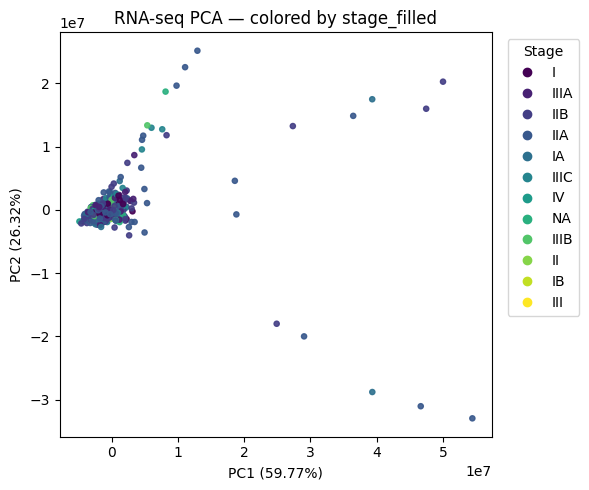

In [48]:
# ============== Cell 4B — Linkage + PCA (quick, robust) ==============
import os, re
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def to_case12(barcode: str | None) -> str | None:
    if not isinstance(barcode, str): return None
    m = re.match(r"^(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})", barcode)
    return m.group(1) if m else None

# Load RNA key
rna_key = pd.read_csv(os.path.join(DATA_DIR, "rnaseq_sample_key.csv"))

# Build sample→case map (support both schemas)
sample_col = "sample_submitter_id" if "sample_submitter_id" in rna_key.columns else "sample_barcode"
if "case_submitter_id" in rna_key.columns:
    samp_to_case = dict(zip(rna_key[sample_col].astype(str), rna_key["case_submitter_id"].astype(str)))
else:
    samp_to_case = {s: to_case12(s) for s in rna_key[sample_col].astype(str)}

# Stage map (use stage_filled if available; fallback to stage_best; else NA)
stage_col = "stage_filled" if "stage_filled" in clinical_df.columns else (
    "stage_best" if "stage_best" in clinical_df.columns else None
)
if stage_col is None:
    print("No stage column available; PCA will plot without coloring.")
    stage_map = {}
else:
    stage_map = dict(zip(clinical_df["case_submitter_id"].astype(str), clinical_df[stage_col]))

# Counts
print("RNA-seq samples:", rnaseq_df.shape[1])
print("Genes:", rnaseq_df.shape[0])

labels_series = pd.Series([stage_map.get(samp_to_case.get(s), None) for s in rnaseq_df.columns],
                          index=rnaseq_df.columns, name="stage")
matched = labels_series.notna().sum()
print(f"Samples with {stage_col or 'stage'} match:", int(matched), "/", rnaseq_df.shape[1])

# PCA: keep top-variance genes to avoid memory blow-up (e.g., top 3000 by variance)
var = rnaseq_df.var(axis=1, skipna=True)
topk = 3000 if len(var) > 3000 else len(var)
top_genes = var.nlargest(topk).index
rna_top = rnaseq_df.loc[top_genes]

# Impute per-gene median and center
row_med = rna_top.median(axis=1, numeric_only=True)
X = rna_top.T.fillna(row_med).T
X = X.subtract(X.mean(axis=1), axis=0).T  # samples × genes

# PCA
pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
emb = pca.fit_transform(X)

# Color by stage (NA → gray)
lab = labels_series.reindex(X.index)
codes, uniques = pd.factorize(lab.fillna("NA"))

plt.figure(figsize=(6,5))
sc = plt.scatter(emb[:,0], emb[:,1], s=14, c=codes, alpha=0.9)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
ttl = "RNA-seq PCA — colored by " + (stage_col if stage_col else "stage (NA)")
plt.title(ttl)

# Legend
handles = [plt.Line2D([0],[0], marker='o', linestyle='', markersize=6,
                      color=sc.cmap(sc.norm(i))) for i in range(len(uniques))]
plt.legend(handles, uniques.astype(str).tolist(), title="Stage", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Pre-Processing to map RNA samples with clinical

In [50]:
# ===================== Clinical staging + linkage, and clean RNA-seq =====================
# - Scans ALL diagnoses per case, normalizes stage strings, picks most-advanced stage → stage_best
# - Fills stage_filled from stage_best (fallbacks preserved)
# - Cleans RNA-seq (drop STAR/HTSeq summary rows)
# - Recomputes linkage coverage (cases + stage)
# =================================================================================================
import os, re, json
import pandas as pd
import numpy as np

# --- 1) Re-fetch diagnoses for all cases and derive robust stage_best ---
filters = {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT_ID]}}
params = {
    "filters": json.dumps(filters),
    "expand": "diagnoses,demographic",
    "format": "JSON",
    "size": "6000"
}
js_full = get_json("/cases", params)

# Canonical normalization + ranking
_STAGE_ORDER = {
    "0":0, "I":1, "IA":1.1, "IB":1.2, "IC":1.3,
    "II":2, "IIA":2.1, "IIB":2.2, "IIC":2.3,
    "III":3, "IIIA":3.1, "IIIB":3.2, "IIIC":3.3,
    "IV":4, "X":-1  # unknown/indeterminate
}
def normalize_stage(s):
    if not isinstance(s, str):
        return None
    t = s.strip().upper()
    # remove common prefixes
    for p in ("STAGE ", "PATHOLOGIC ", "CLINICAL ", "AJCC "):
        t = t.replace(p, "")
    # keep canonical tokens (0, I, IIA, ..., IV, X)
    m = re.match(r"^(0|I{1,3}(?:A|B|C)?|IV|X)$", t)
    return m.group(1) if m else None

def pick_most_advanced(diags):
    best, rank = None, -1
    if not diags:
        return None
    for d in diags:
        for k in ("tumor_stage", "ajcc_pathologic_stage", "pathologic_stage",
                  "ajcc_clinical_stage", "clinical_stage"):
            v = normalize_stage(d.get(k))
            if v is None:
                continue
            r = _STAGE_ORDER.get(v, -1)
            if r > rank:
                best, rank = v, r
    return best

stage_rows = []
for case in js_full.get("data", {}).get("hits", []):
    stage_rows.append({
        "case_submitter_id": case.get("submitter_id"),
        "stage_best": pick_most_advanced(case.get("diagnoses") or [])
    })
stage_df = pd.DataFrame(stage_rows)

# --- 2) Merge best stage into existing clinical_df and build stage_filled ---
clinical_df = clinical_df.merge(stage_df, on="case_submitter_id", how="left")
if "diag_tumor_stage" in clinical_df.columns:
    clinical_df["stage_filled"] = clinical_df["stage_best"].where(
        clinical_df["stage_best"].notna(),
        clinical_df["diag_tumor_stage"].map(normalize_stage)
    )
else:
    clinical_df["stage_filled"] = clinical_df["stage_best"]

clinical_up_path = os.path.join(DATA_DIR, "clinical_data_upgraded.csv")
clinical_df.to_csv(clinical_up_path, index=False)
print("Upgraded clinical saved →", clinical_up_path)

# --- 3) Clean RNA-seq matrix: drop STAR/HTSeq summary rows (N_* and __*) ---
try:
    rnaseq_df
except NameError:
    # load if not in memory
    rna_path = os.path.join(DATA_DIR, "rnaseq_expression.csv")
    rnaseq_df = pd.read_csv(rna_path, index_col=0, low_memory=False)

before = rnaseq_df.shape
keep_mask = ~rnaseq_df.index.astype(str).str.match(r'^(N_|__)')
rnaseq_df = rnaseq_df.loc[keep_mask].copy()
after = rnaseq_df.shape
print(f"RNA-seq cleaned: {before} → {after}")

# --- 4) Recompute linkage coverage (case vs stage) ---
def to_case12(sample_id: str | None):
    if isinstance(sample_id, str):
        m = re.match(r"^(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})", sample_id)
        return m.group(1) if m else None
    return None

rna_cases = pd.Series({col: to_case12(col) for col in rnaseq_df.columns}, name="case_from_sample")
clinical_cases = set(clinical_df["case_submitter_id"].dropna().astype(str))

case_present = rna_cases.map(lambda c: c in clinical_cases)
print(f"Case coverage: {int(case_present.sum())} / {len(rna_cases)}")

case_to_stage = dict(zip(clinical_df["case_submitter_id"].astype(str), clinical_df["stage_filled"]))
stage_present = rna_cases.map(lambda c: pd.notna(case_to_stage.get(str(c))))
print(f"Stage coverage (filled): {int(stage_present.sum())} / {len(rna_cases)}")

# Show a few unmatched cases for audit
if stage_present.sum() < len(rna_cases):
    unm = rna_cases[~stage_present].head(8)
    audit_df = pd.DataFrame({"sample_col": unm.index, "case12": unm.values})
    print("\nExamples of unmatched cases (no stage):")
    display(audit_df)


Upgraded clinical saved → ./data/raw/clinical_data_upgraded.csv
RNA-seq cleaned: (60664, 500) → (60660, 500)
Case coverage: 498 / 498
Stage coverage (filled): 486 / 498

Examples of unmatched cases (no stage):


,sample_col,case12
0,TCGA-A8-A09A-01A,TCGA-A8-A09A
1,TCGA-B6-A0WW-01A,TCGA-B6-A0WW
2,TCGA-A8-A099-01A,TCGA-A8-A099
3,TCGA-AR-A0TZ-01A,TCGA-AR-A0TZ
4,TCGA-D8-A147-01A,TCGA-D8-A147
5,TCGA-A8-A07E-01A,TCGA-A8-A07E
6,TCGA-BH-A0B2-01A,TCGA-BH-A0B2
7,TCGA-A8-A09C-01A,TCGA-A8-A09C


# Exploratory Data Analysis 

In [51]:
# =========================
# Cell 1 — Setup & logging
# =========================
import os, json, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False

warnings.filterwarnings("ignore")

# Directories
DATA_DIR     = "./data/raw"
RESULTS_DIR  = "./results/eda"
FIG_DIR      = "./figures/eda"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Lightweight JSONL logger
def log_exp(status, exp_name, description="", reason="", resolution="", extra=None):
    entry = {
        "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": exp_name,
        "status": status,
        "description": description,
        "failure_reason": reason,
        "resolution": resolution,
        "extra": extra or {}
    }
    with open(os.path.join(RESULTS_DIR, "experiment_logs.jsonl"), "a") as f:
        f.write(json.dumps(entry) + "\n")
    print(f"[{status.upper()}] {exp_name} — {description or reason or ''}")


In [53]:
# =============================================
# Cell 2 — Load clinical/RNA/methyl + normalize (provenance-safe)
# =============================================
import os
import pandas as pd
import numpy as np

def _maybe_read_csv(path, **kwargs):
    return pd.read_csv(path, **kwargs) if os.path.exists(path) else pd.DataFrame()

DATA_DIR = "./data/raw"

# Prefer upgraded clinical if present
clinical_path_up = os.path.join(DATA_DIR, "clinical_data_upgraded.csv")
clinical_path    = clinical_path_up if os.path.exists(clinical_path_up) else os.path.join(DATA_DIR, "clinical_data.csv")

clinical_df = _maybe_read_csv(clinical_path)
rnaseq_df   = _maybe_read_csv(os.path.join(DATA_DIR, "rnaseq_expression.csv"), index_col=0, low_memory=False)
methyl_df   = _maybe_read_csv(os.path.join(DATA_DIR, "methylation_beta.csv"), index_col=0, low_memory=False)

# ---- Clinical: normalize names WITHOUT clobbering provenance
rename_soft = {
    "demo_gender": "gender",
    "demo_age_at_index_years": "age_at_diagnosis",
    "diag_age_at_diagnosis_days": "age_at_diag_days",
}
for src, dst in rename_soft.items():
    if src in clinical_df.columns and dst not in clinical_df.columns:
        clinical_df.rename(columns={src: dst}, inplace=True)

# Keep raw tumor_stage if it exists; add stage_used as canonical choice
# Priority: stage_filled > stage_best > tumor_stage
if "stage_filled" in clinical_df.columns:
    clinical_df["stage_used"] = clinical_df["stage_filled"]
elif "stage_best" in clinical_df.columns:
    clinical_df["stage_used"] = clinical_df["stage_best"]
elif "tumor_stage" in clinical_df.columns:
    clinical_df["stage_used"] = clinical_df["tumor_stage"]
else:
    clinical_df["stage_used"] = pd.NA

# Ensure case id is string (for merges)
if "case_submitter_id" in clinical_df.columns:
    clinical_df["case_submitter_id"] = clinical_df["case_submitter_id"].astype(str)

# ---- Omics: force numeric
if not rnaseq_df.empty:
    rnaseq_df = rnaseq_df.apply(pd.to_numeric, errors="coerce")

# Clean RNA-seq: drop STAR/HTSeq summary rows (N_* and __*)
if not rnaseq_df.empty:
    before = rnaseq_df.shape
    mask = ~rnaseq_df.index.astype(str).str.match(r'^(N_|__)')
    rnaseq_df = rnaseq_df.loc[mask].copy()
    after = rnaseq_df.shape
    if before != after:
        log_exp("success", "RNA_Clean_SummaryRows",
                description=f"Dropped STAR/HTSeq summary rows: {before} → {after}")

# ---- Methylation: numeric & OPTIONAL coverage filter (so inner-join ≠ tiny matrix)
if not methyl_df.empty:
    methyl_df = methyl_df.apply(pd.to_numeric, errors="coerce")
    # OPTIONAL: keep CpGs observed in ≥80% of samples to avoid over-shrinking
    cov_thresh = 0.80
    min_non_na = int(np.ceil(cov_thresh * methyl_df.shape[1]))
    keep = methyl_df.notna().sum(axis=1) >= min_non_na
    kept_before = methyl_df.shape[0]
    methyl_df = methyl_df.loc[keep].copy()
    kept_after = methyl_df.shape[0]
    if kept_after != kept_before:
        log_exp("success", "Methylation_CoverageFilter",
                description=f"Kept CpGs with ≥{int(cov_thresh*100)}% coverage: {kept_before} → {kept_after}")

# ---- Presence report
print("Loaded:")
print(f"  Clinical:    {clinical_df.shape}")
print(f"  RNA-seq:     {rnaseq_df.shape}")
print(f"  Methylation: {methyl_df.shape}")

# ---- NaN logging
for mod, df in [("Clinical", clinical_df), ("RNA-Seq", rnaseq_df), ("Methylation", methyl_df)]:
    if not df.empty:
        nan_count = int(df.isnull().sum().sum())
        if nan_count > 0:
            log_exp("warning", f"EDA_{mod}_NaNs", description="NaNs detected", extra={"nan_count": nan_count})


[SUCCESS] RNA_Clean_SummaryRows — Dropped STAR/HTSeq summary rows: (60664, 500) → (60660, 500)
Loaded:
  Clinical:    (1098, 12)
  RNA-seq:     (60660, 500)
  Methylation: (14164, 1097)
[WARNING] EDA_Clinical_NaNs — NaNs detected


✅ Saved ./data/raw/clinical_data_upgraded.csv  | shape=(1098, 8)


,case_submitter_id,gender,age_at_diagnosis,stage_best,stage_used,vital_status,label_vital_binary,sample_types_present
0,TCGA-Z7-A8R6,female,46.0,I,I,Alive,0.0,Blood Derived Normal;Primary Tumor
1,TCGA-A8-A09A,female,40.0,NaN,NaN,Alive,0.0,Blood Derived Normal;Primary Tumor
2,TCGA-A2-A0YL,female,48.0,IIIA,IIIA,Alive,0.0,Blood Derived Normal;Primary Tumor


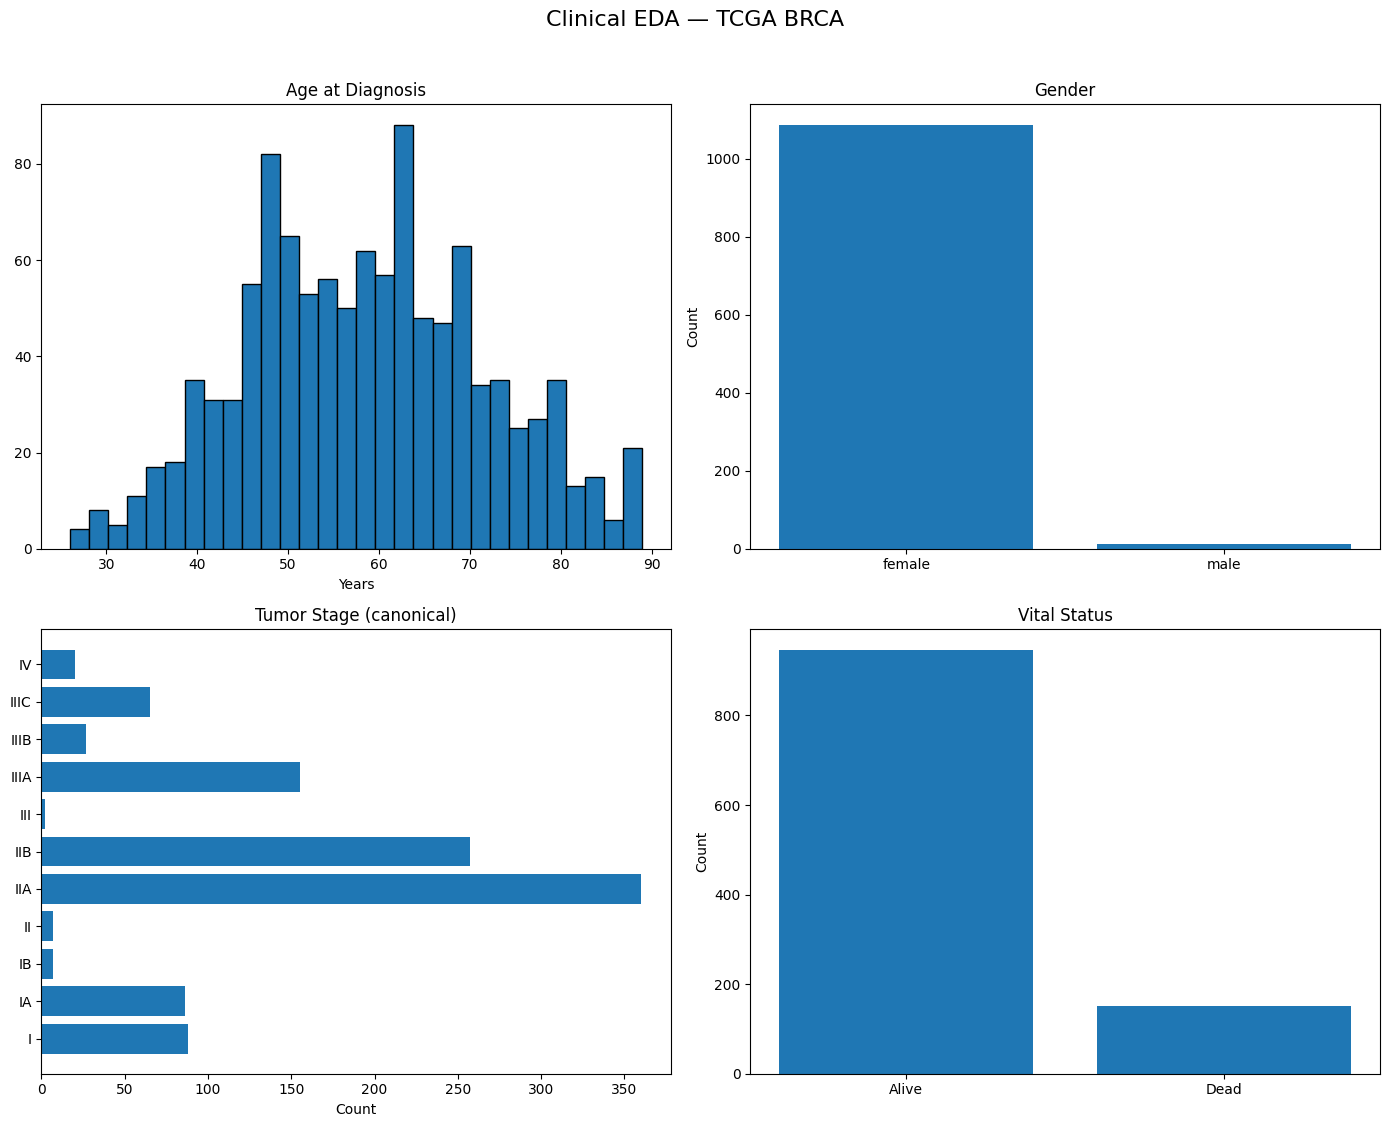

Labels from vital_status — total labeled: 1097 | Alive: 945 | Dead: 152


In [54]:
# ==============================================
# Clinical Fetch + Canonicalization + Plots (robust)
# ==============================================
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ID = "TCGA-BRCA"
DATA_DIR = "./data/raw"
os.makedirs(DATA_DIR, exist_ok=True)

# assume get_json() already exists from a previous cell

# -----------------------------
# 1) FETCH clinical w/ stage & vital
# -----------------------------
filters = {"op": "in", "content": {"field": "cases.project.project_id", "value": [PROJECT_ID]}}
params = {
    "filters": json.dumps(filters),
    "expand": "demographic,diagnoses,follow_ups,samples",
    "format": "JSON",
    "size": "6000",
}
js = get_json("/cases", params)

# --- stage normalization and ranking ---
_STAGE_ORDER = {
    "0":0, "I":1, "IA":1.1, "IB":1.2, "IC":1.3,
    "II":2, "IIA":2.1, "IIB":2.2, "IIC":2.3,
    "III":3, "IIIA":3.1, "IIIB":3.2, "IIIC":3.3,
    "IV":4, "IVA":4.1, "IVB":4.2, "X":-1
}
_VALID_STAGES = set(_STAGE_ORDER.keys())

def _normalize_stage(raw):
    """Map raw stage strings to canonical tokens: 0, I, IIA, ..., IV, IVA/IVB, X (unknown)."""
    if not isinstance(raw, str):
        return np.nan
    t = raw.strip().upper()
    # remove common prefixes and whitespace artifacts
    for p in ("STAGE ", "PATHOLOGIC ", "CLINICAL ", "AJCC "):
        t = t.replace(p, "")
    t = re.sub(r"\s+", "", t)  # "II A" -> "IIA"
    # common aliases
    aliases = {
        "STAGE0":"0", "STAGEI":"I", "STAGEII":"II", "STAGEIII":"III", "STAGEIV":"IV",
        "UNKNOWN":"X", "NOT REPORTED":"X", "N/A":"X", "NA":"X", "UNAVAILABLE":"X"
    }
    t = aliases.get(t, t)
    # compress variants like "STAGE IVA" etc already removed
    if t in _VALID_STAGES:
        return t
    # handle things like "II (T2N0M0)" -> "II"
    m = re.match(r"^(0|I{1,3}|IV)([ABC])?$", t)
    if m:
        base, sub = m.group(1), m.group(2) or ""
        cand = base + sub
        return cand if cand in _VALID_STAGES else base
    return np.nan

def _pick_most_advanced(diags):
    """Pick highest-ranked stage across all diagnosis entries."""
    best, rank = np.nan, -1
    if not diags:
        return np.nan
    for d in diags:
        for k in ("tumor_stage","ajcc_pathologic_stage","pathologic_stage","ajcc_clinical_stage","clinical_stage"):
            v = _normalize_stage(d.get(k))
            if isinstance(v, str):
                r = _STAGE_ORDER.get(v, -1)
                if r > rank:
                    best, rank = v, r
    return best

def _first_nonnull_vital(case_obj):
    """Search demographic → diagnoses → follow_ups for first non-empty vital_status."""
    chain = []
    demo = case_obj.get("demographic")
    if isinstance(demo, dict):
        chain.append(demo)
    chain.extend(list(case_obj.get("diagnoses") or []))
    chain.extend(list(case_obj.get("follow_ups") or []))
    for node in chain:
        v = node.get("vital_status") if isinstance(node, dict) else None
        if isinstance(v, str) and v.strip():
            return v.strip()
    return np.nan

def _label_from_vital(v):
    """Map vital_status → binary label. Alive=0, Dead=1; unknown/NA -> NaN."""
    if not isinstance(v, str):
        return np.nan
    t = v.strip().lower()
    if t == "alive":
        return 0
    if t == "dead":
        return 1
    return np.nan

rows = []
for case in js.get("data", {}).get("hits", []):
    demo   = case.get("demographic") or {}
    diags  = case.get("diagnoses") or []
    stage  = _pick_most_advanced(diags)
    vital  = _first_nonnull_vital(case)
    samp_types = sorted({ s.get("sample_type") for s in (case.get("samples") or []) if isinstance(s, dict) and s.get("sample_type") })
    rows.append({
        "case_submitter_id": case.get("submitter_id"),
        "gender": demo.get("gender"),
        "age_at_diagnosis": demo.get("age_at_index"),
        "stage_best": stage,
        "stage_used": stage,          # canonical column to use downstream
        "vital_status": vital,
        "label_vital_binary": _label_from_vital(vital),
        "sample_types_present": ";".join(samp_types),
    })

clinical_df = pd.DataFrame(rows)
out_path = os.path.join(DATA_DIR, "clinical_data_upgraded.csv")
clinical_df.to_csv(out_path, index=False)
print(f"✅ Saved {out_path}  | shape={clinical_df.shape}")
display(clinical_df.head(3))

# -----------------------------
# 2) PLOTS (guarded)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle("Clinical EDA — TCGA BRCA", fontsize=16, y=1.02)

# AGE
if "age_at_diagnosis" in clinical_df.columns:
    ages = pd.to_numeric(clinical_df["age_at_diagnosis"], errors="coerce").dropna()
    axes[0,0].hist(ages, bins=30, edgecolor="black")
    axes[0,0].set_title("Age at Diagnosis")
    axes[0,0].set_xlabel("Years")

# GENDER
if "gender" in clinical_df.columns:
    gcounts = clinical_df["gender"].dropna().value_counts()
    axes[0,1].bar(gcounts.index.astype(str), gcounts.values)
    axes[0,1].set_title("Gender")
    axes[0,1].set_ylabel("Count")

# STAGE
if "stage_used" in clinical_df.columns:
    sc = clinical_df["stage_used"].dropna().astype(str).value_counts().sort_index()
    axes[1,0].barh(sc.index, sc.values)
    axes[1,0].set_title("Tumor Stage (canonical)")
    axes[1,0].set_xlabel("Count")

# VITAL STATUS
if "vital_status" in clinical_df.columns:
    vc = clinical_df["vital_status"].dropna().value_counts()
    axes[1,1].bar(vc.index.astype(str), vc.values)
    axes[1,1].set_title("Vital Status")
    axes[1,1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Small integrity printout (useful for downstream splits)
n_label = int(pd.Series(clinical_df["label_vital_binary"]).dropna().shape[0])
n_alive = int((clinical_df["label_vital_binary"] == 0).sum())
n_dead  = int((clinical_df["label_vital_binary"] == 1).sum())
print(f"Labels from vital_status — total labeled: {n_label} | Alive: {n_alive} | Dead: {n_dead}")


RNA-SEQ MODALITY EDA
Shape: (60660, 500) (genes × samples)
Missing values: 0
Sparsity (zeros / all entries): 46.34%


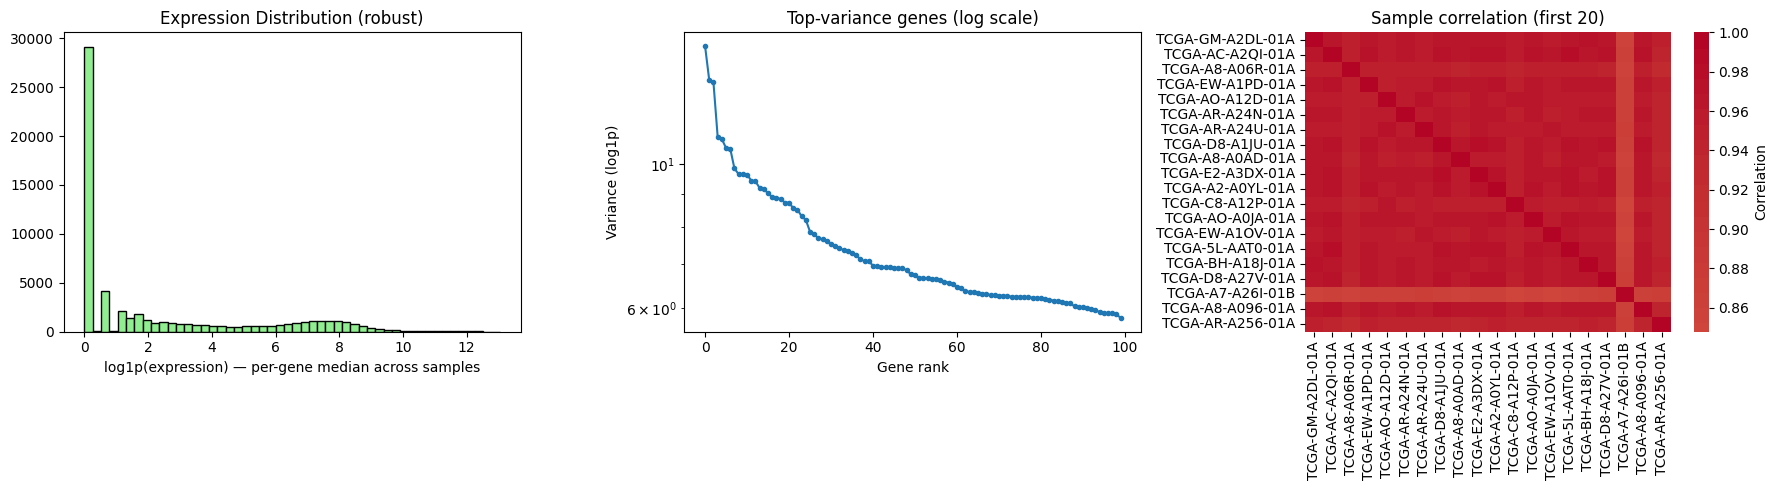

[SUCCESS] EDA_RNASeq_Figs — Saved ./figures/eda/rnaseq_characteristics.png


In [55]:
# ==============================================
# Cell 4 — RNA-seq modality plots (unimodal EDA)
# ==============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if rnaseq_df.empty:
    print("RNA-seq not found — skipping RNA-seq EDA.")
    log_exp("failed", "EDA_RNASeq", reason="rnaseq_df empty")
else:
    print("="*50, "\nRNA-SEQ MODALITY EDA\n", "="*50)
    print(f"Shape: {rnaseq_df.shape} (genes × samples)")

    # Ensure numeric and report missing/sparsity
    rna = rnaseq_df.apply(pd.to_numeric, errors="coerce")
    n_missing = int(rna.isna().sum().sum())
    sparsity = float((rna == 0).sum().sum()) / float(rna.size)
    print(f"Missing values: {n_missing}")
    print(f"Sparsity (zeros / all entries): {sparsity:.2%}")

    # Precompute log1p for count-like data (works fine for FPKM too)
    rna_log1p = np.log1p(rna)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1) Expression distribution — use median across samples for a robust slice
    med_sample = rna_log1p.median(axis=1, skipna=True)  # median per gene
    axes[0].hist(med_sample.dropna(), bins=50, edgecolor="black", color="lightgreen")
    axes[0].set_xlabel("log1p(expression) — per-gene median across samples")
    axes[0].set_title("Expression Distribution (robust)")

    # 2) Gene variance (top 100) on log1p scale
    gvar = rna_log1p.var(axis=1, skipna=True).sort_values(ascending=False)
    k = min(100, len(gvar))
    axes[1].plot(range(k), gvar.head(k).values, marker="o", ms=3)
    axes[1].set_xlabel("Gene rank")
    axes[1].set_ylabel("Variance (log1p)")
    axes[1].set_yscale("log")
    axes[1].set_title("Top-variance genes (log scale)")

    # 3) Sample-wise correlation heatmap (first n samples for speed)
    n = min(20, rna_log1p.shape[1])
    if n >= 2:
        corr = rna_log1p.iloc[:, :n].corr(method="pearson", min_periods=10)
        sns.heatmap(corr, cmap="coolwarm", center=0, ax=axes[2], cbar_kws={"label": "Correlation"})
        axes[2].set_title(f"Sample correlation (first {n})")
    else:
        axes[2].axis("off")
        axes[2].text(0.5, 0.5, "Not enough samples for correlation", ha="center", va="center")

    plt.tight_layout()
    out_path = os.path.join(FIG_DIR, "rnaseq_characteristics.png")
    plt.savefig(out_path, dpi=300)
    plt.show()

    log_exp(
        "success",
        "EDA_RNASeq_Figs",
        description=f"Saved {out_path}",
        extra={"missing": n_missing, "sparsity": f"{sparsity:.4f}"}
    )


METHYLATION MODALITY EDA
Shape: (25977, 60) (CpGs x samples)
Missing values: 111185


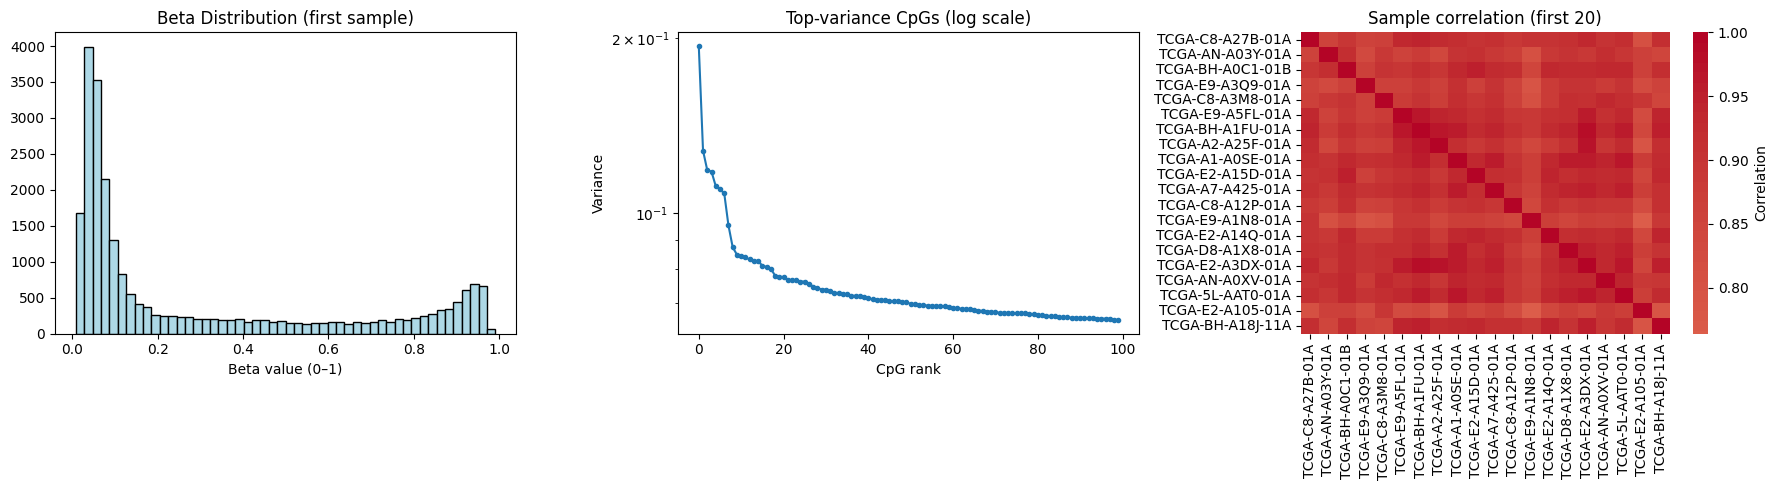

[SUCCESS] EDA_Methylation_Figs — Saved ./figures/eda/methylation_characteristics.png


In [22]:
# ==================================================
# Cell 5 — Methylation modality plots (unimodal EDA)
# ==================================================
if methyl_df.empty:
    print("Methylation not found — skipping methylation EDA.")
    log_exp("warning", "EDA_Methylation", reason="methyl_df empty", resolution="Download later")
else:
    print("="*50, "\nMETHYLATION MODALITY EDA\n", "="*50)
    print(f"Shape: {methyl_df.shape} (CpGs x samples)")
    print("Missing values:", int(methyl_df.isna().sum().sum()))

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Beta distribution (first sample)
    vals = methyl_df.iloc[:, 0].dropna()
    axes[0].hist(vals, bins=50, edgecolor="black", color="lightblue")
    axes[0].set_xlabel("Beta value (0–1)")
    axes[0].set_title("Beta Distribution (first sample)")

    # CpG variance (top 100)
    cvar = methyl_df.var(axis=1, skipna=True).sort_values(ascending=False)
    axes[1].plot(range(min(100, len(cvar))), cvar.head(100).values, marker="o", ms=3)
    axes[1].set_xlabel("CpG rank")
    axes[1].set_ylabel("Variance")
    axes[1].set_yscale("log")
    axes[1].set_title("Top-variance CpGs (log scale)")

    # Sample-wise correlation heatmap (first n)
    n = min(20, methyl_df.shape[1])
    if n >= 2:
        corr = methyl_df.iloc[:, :n].corr()
        sns.heatmap(corr, cmap="coolwarm", center=0, ax=axes[2], cbar_kws={"label": "Correlation"})
        axes[2].set_title(f"Sample correlation (first {n})")
    else:
        axes[2].axis("off")
        axes[2].text(0.5, 0.5, "Not enough samples for correlation", ha="center", va="center")

    plt.tight_layout()
    out_path = os.path.join(FIG_DIR, "methylation_characteristics.png")
    plt.savefig(out_path, dpi=300)
    plt.show()
    log_exp("success", "EDA_Methylation_Figs", description=f"Saved {out_path}")


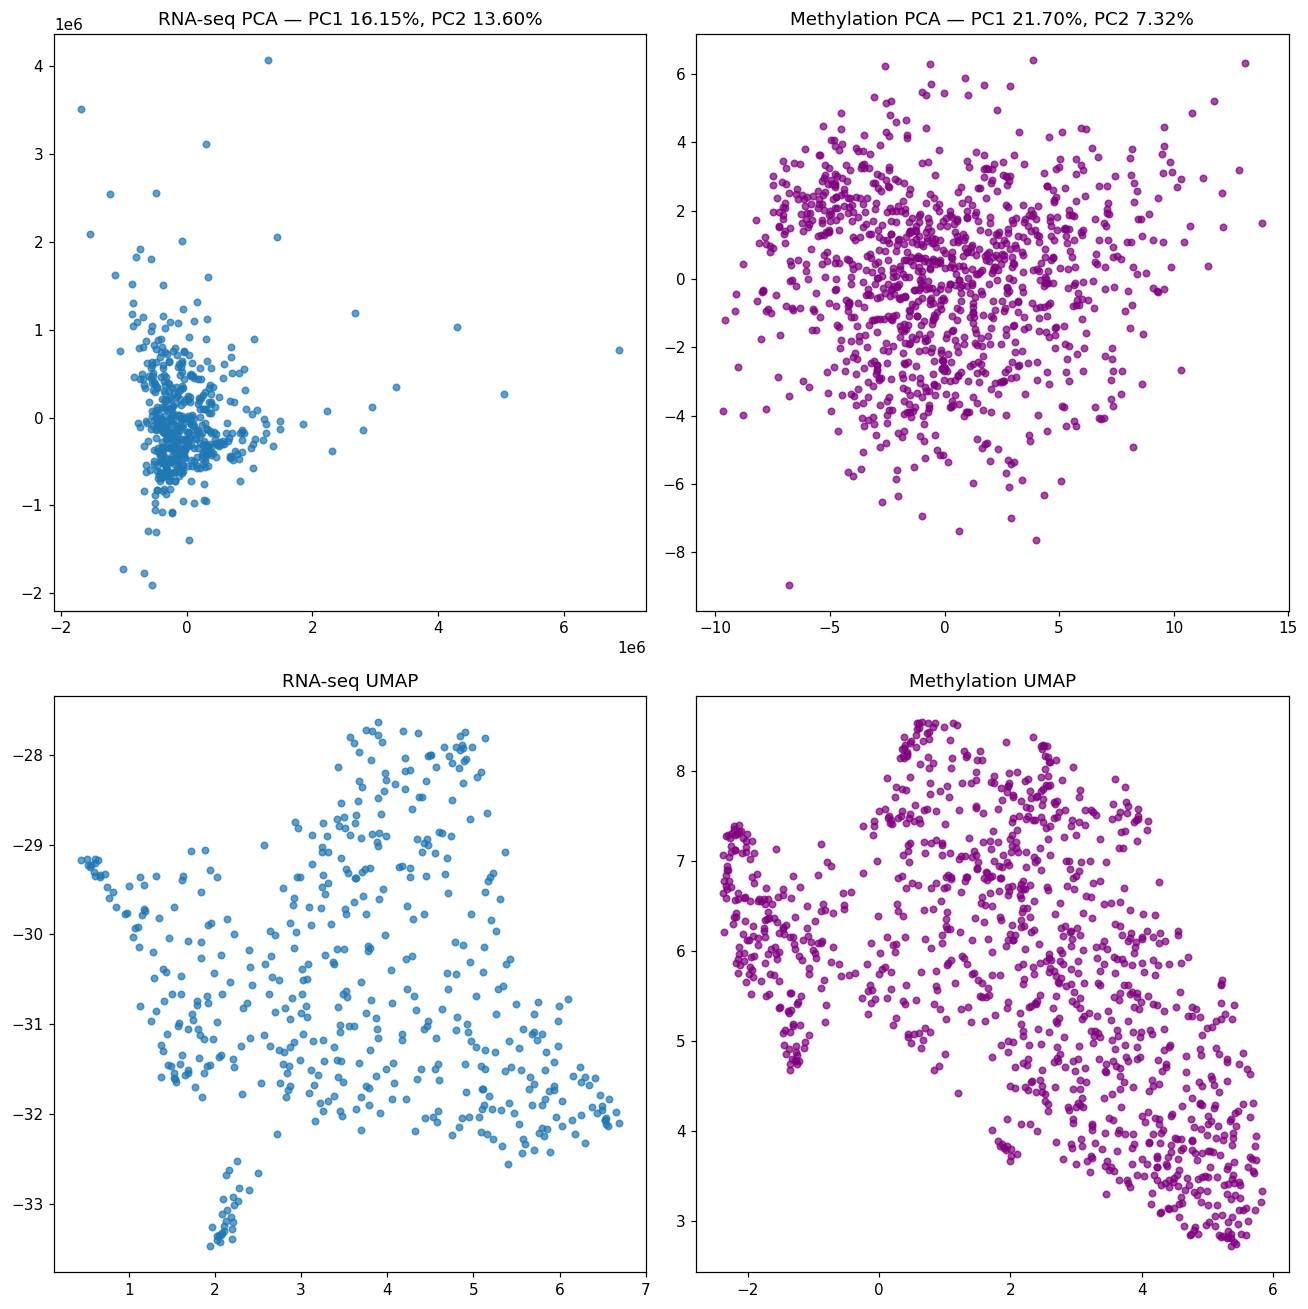

[SUCCESS] EDA_DimRed_Figs — Saved ./figures/eda/data_heterogeneity.png


In [128]:
# ===============================================
# Cell 6 — Dimensionality reduction (RNA & Meth)
# ===============================================
def pca_2d_from_matrix(X_df, n_features=2000, seed=42):
    if X_df.empty or X_df.shape[1] < 2:
        return None, None
    # top variance features
    feats = X_df.var(axis=1, skipna=True).nlargest(min(n_features, X_df.shape[0])).index
    X = X_df.loc[feats].copy()
    # per-feature median impute + center
    X = X.apply(lambda s: s.fillna(s.median()), axis=1)
    Xc = (X.T - X.T.mean(axis=0)).T
    pca = PCA(n_components=2, random_state=seed)
    emb = pca.fit_transform(Xc.T)  # samples x 2
    return emb, pca.explained_variance_ratio_

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# RNA PCA
if rnaseq_df.empty or rnaseq_df.shape[1] < 2:
    axes[0,0].axis("off"); axes[1,0].axis("off")
    axes[0,0].text(0.5, 0.5, "RNA-seq not available", ha="center", va="center")
else:
    emb, var = pca_2d_from_matrix(rnaseq_df)
    if emb is not None:
        axes[0,0].scatter(emb[:,0], emb[:,1], s=18, alpha=0.7)
        axes[0,0].set_title(f"RNA-seq PCA — PC1 {var[0]:.2%}, PC2 {var[1]:.2%}")
    else:
        axes[0,0].axis("off"); axes[0,0].text(0.5,0.5,"RNA PCA failed",ha="center",va="center")

    # UMAP (optional)
    if UMAP_AVAILABLE and rnaseq_df.shape[1] >= 3:
        try:
            feats = rnaseq_df.var(axis=1, skipna=True).nlargest(min(2000, rnaseq_df.shape[0])).index
            X = rnaseq_df.loc[feats].apply(lambda s: s.fillna(s.median()), axis=1)
            Xc = (X.T - X.T.mean(axis=0)).T
            nn = max(2, min(15, Xc.shape[1] - 1))
            emb_u = umap.UMAP(random_state=42, n_neighbors=nn).fit_transform(Xc.T)
            axes[1,0].scatter(emb_u[:,0], emb_u[:,1], s=18, alpha=0.7)
            axes[1,0].set_title("RNA-seq UMAP")
        except Exception as e:
            axes[1,0].axis("off"); axes[1,0].text(0.5,0.5,f"UMAP failed:\n{e}",ha="center",va="center")
    else:
        axes[1,0].axis("off"); axes[1,0].text(0.5,0.5,"UMAP unavailable",ha="center",va="center")

# Methyl PCA
if methyl_df.empty or methyl_df.shape[1] < 2:
    axes[0,1].axis("off"); axes[1,1].axis("off")
    axes[0,1].text(0.5, 0.5, "Methylation not available", ha="center", va="center")
else:
    emb, var = pca_2d_from_matrix(methyl_df)
    if emb is not None:
        axes[0,1].scatter(emb[:,0], emb[:,1], s=18, alpha=0.7, color="purple")
        axes[0,1].set_title(f"Methylation PCA — PC1 {var[0]:.2%}, PC2 {var[1]:.2%}")
    else:
        axes[0,1].axis("off"); axes[0,1].text(0.5,0.5,"Meth PCA failed",ha="center",va="center")

    if UMAP_AVAILABLE and methyl_df.shape[1] >= 3:
        try:
            feats = methyl_df.var(axis=1, skipna=True).nlargest(min(2000, methyl_df.shape[0])).index
            X = methyl_df.loc[feats].apply(lambda s: s.fillna(s.median()), axis=1)
            Xc = (X.T - X.T.mean(axis=0)).T
            nn = max(2, min(15, Xc.shape[1] - 1))
            emb_u = umap.UMAP(random_state=42, n_neighbors=nn).fit_transform(Xc.T)
            axes[1,1].scatter(emb_u[:,0], emb_u[:,1], s=18, alpha=0.7, color="purple")
            axes[1,1].set_title("Methylation UMAP")
        except Exception as e:
            axes[1,1].axis("off"); axes[1,1].text(0.5,0.5,f"UMAP failed:\n{e}",ha="center",va="center")
    else:
        axes[1,1].axis("off"); axes[1,1].text(0.5,0.5,"UMAP unavailable",ha="center",va="center")

plt.tight_layout()
out_path = os.path.join(FIG_DIR, "data_heterogeneity.png")
plt.savefig(out_path, dpi=300)
plt.show()
log_exp("success", "EDA_DimRed_Figs", description=f"Saved {out_path}")


## Saving PCA embeddings

In [ ]:
# ===============================================
# Cell 6 — Dimensionality reduction (RNA & Meth)
# ===============================================

import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

os.makedirs("results/pca_embeddings", exist_ok=True)

# Helper function (unchanged)
def pca_2d_from_matrix(X_df, n_features=2000, seed=42):
    if X_df.empty or X_df.shape[1] < 2:
        return None, None
    feats = X_df.var(axis=1, skipna=True).nlargest(min(n_features, X_df.shape[0])).index
    X = X_df.loc[feats].copy()
    X = X.apply(lambda s: s.fillna(s.median()), axis=1)
    Xc = (X.T - X.T.mean(axis=0)).T
    pca = PCA(n_components=2, random_state=seed)
    emb = pca.fit_transform(Xc.T)
    return emb, pca.explained_variance_ratio_

# 🚀 NEW helper function — compute high-dimensional PCA & save
def save_pca_embeddings(X_df, name, n_features=2000, n_components=50):
    feats = X_df.var(axis=1, skipna=True).nlargest(min(n_features, X_df.shape[0])).index
    X = X_df.loc[feats].copy()
    X = X.apply(lambda s: s.fillna(s.median()), axis=1)
    Xc = (X.T - X.T.mean(axis=0)).T  # samples × features

    pca = PCA(n_components=n_components, random_state=42)
    emb = pca.fit_transform(Xc)     # shape: samples × components

    # Save to disk
    np.save(f"results/pca_embeddings/{name}_pca.npy", emb)
    pd.DataFrame(emb, index=Xc.index).to_csv(f"results/pca_embeddings/{name}_pca.csv")

    print(f"Saved {name} PCA embedding:", emb.shape)
    return emb

# ------------------ Plotting PCA/UMAP ------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# ---------- RNA ----------
if rnaseq_df.empty or rnaseq_df.shape[1] < 2:
    axes[0,0].axis("off"); axes[1,0].axis("off")
    axes[0,0].text(0.5, 0.5, "RNA-seq not available", ha="center", va="center")
else:
    emb, var = pca_2d_from_matrix(rnaseq_df)
    if emb is not None:
        axes[0,0].scatter(emb[:,0], emb[:,1], s=18, alpha=0.7)
        axes[0,0].set_title(f"RNA-seq PCA — PC1 {var[0]:.2%}, PC2 {var[1]:.2%}")

        # Save high-dimensional PCA embeddings
        save_pca_embeddings(rnaseq_df, name="rna", n_components=50)

    # UMAP
    if UMAP_AVAILABLE and rnaseq_df.shape[1] >= 3:
        try:
            feats = rnaseq_df.var(axis=1, skipna=True).nlargest(min(2000, rnaseq_df.shape[0])).index
            X = rnaseq_df.loc[feats].apply(lambda s: s.fillna(s.median()), axis=1)
            Xc = (X.T - X.T.mean(axis=0)).T
            nn = max(2, min(15, Xc.shape[1] - 1))
            emb_u = umap.UMAP(random_state=42, n_neighbors=nn).fit_transform(Xc.T)
            axes[1,0].scatter(emb_u[:,0], emb_u[:,1], s=18, alpha=0.7)
            axes[1,0].set_title("RNA-seq UMAP")
        except Exception as e:
            axes[1,0].axis("off"); axes[1,0].text(0.5,0.5,f"UMAP failed:\n{e}",ha="center",va="center")
    else:
        axes[1,0].axis("off"); axes[1,0].text(0.5,0.5,"UMAP unavailable",ha="center",va="center")

# ---------- Methylation ----------
if methyl_df.empty or methyl_df.shape[1] < 2:
    axes[0,1].axis("off"); axes[1,1].axis("off")
    axes[0,1].text(0.5, 0.5, "Methylation not available", ha="center", va="center")
else:
    emb, var = pca_2d_from_matrix(methyl_df)
    if emb is not None:
        axes[0,1].scatter(emb[:,0], emb[:,1], s=18, alpha=0.7, color="purple")
        axes[0,1].set_title(f"Methylation PCA — PC1 {var[0]:.2%}, PC2 {var[1]:.2%}")

        # Save high-dimensional PCA embeddings
        save_pca_embeddings(methyl_df, name="methylation", n_components=50)

    if UMAP_AVAILABLE and methyl_df.shape[1] >= 3:
        try:
            feats = methyl_df.var(axis=1, skipna=True).nlargest(min(2000, methyl_df.shape[0])).index
            X = methyl_df.loc[feats].apply(lambda s: s.fillna(s.median()), axis=1)
            Xc = (X.T - X.T.mean(axis=0)).T
            nn = max(2, min(15, Xc.shape[1] - 1))
            emb_u = umap.UMAP(random_state=42, n_neighbors=nn).fit_transform(Xc.T)
            axes[1,1].scatter(emb_u[:,0], emb_u[:,1], s=18, alpha=0.7, color="purple")
            axes[1,1].set_title("Methylation UMAP")
        except Exception as e:
            axes[1,1].axis("off"); axes[1,1].text(0.5,0.5,f"UMAP failed:\n{e}",ha="center",va="center")
    else:
        axes[1,1].axis("off"); axes[1,1].text(0.5,0.5,"UMAP unavailable",ha="center",va="center")

plt.tight_layout()
out_path = os.path.join(FIG_DIR, "data_heterogeneity.png")
plt.savefig(out_path, dpi=300)
plt.show()
log_exp("success", "EDA_DimRed_Figs", description=f"Saved {out_path}")

PC1 alignment (RNA vs Methylation): r = 0.089


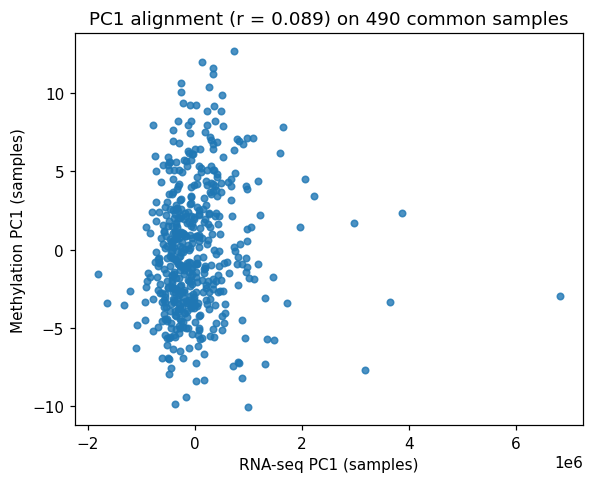

[SUCCESS] EDA_CrossModality_PC1 — Saved ./figures/eda/cross_modality_pc1_alignment.png


In [129]:
# ==========================================================
# Cell 7 — Cross-modality sanity: PC1 alignment (RNA vs Meth)
# ==========================================================
if rnaseq_df.empty or methyl_df.empty:
    print("One or both modalities missing — skipping cross-modality check.")
    log_exp("warning", "EDA_CrossModality", reason="missing modality")
else:
    common = list(set(rnaseq_df.columns) & set(methyl_df.columns))
    if len(common) < 3:
        print(f"Common samples too few ({len(common)}) — skipping cross-modality check.")
        log_exp("warning", "EDA_CrossModality", reason="too few common samples", extra={"n_common": len(common)})
    else:
        # Build centered subsets on common samples
        r_top = rnaseq_df.var(axis=1, skipna=True).nlargest(min(2000, rnaseq_df.shape[0])).index
        m_top = methyl_df.var(axis=1, skipna=True).nlargest(min(2000, methyl_df.shape[0])).index

        R = rnaseq_df.loc[r_top, common].copy()
        R = R.apply(lambda s: s.fillna(s.median()), axis=0)
        R = (R.T - R.T.mean(axis=0)).T

        M = methyl_df.loc[m_top, common].copy()
        M = M.apply(lambda s: s.fillna(s.median()), axis=0)
        M = (M.T - M.T.mean(axis=0)).T

        r_pc1 = PCA(n_components=1, random_state=42).fit_transform(R.T).ravel()
        m_pc1 = PCA(n_components=1, random_state=42).fit_transform(M.T).ravel()
        r = np.corrcoef(r_pc1, m_pc1)[0, 1]
        print(f"PC1 alignment (RNA vs Methylation): r = {r:.3f}")

        # Scatter for sanity
        plt.figure(figsize=(5.5, 4.5))
        plt.scatter(r_pc1, m_pc1, s=18, alpha=0.8)
        plt.xlabel("RNA-seq PC1 (samples)")
        plt.ylabel("Methylation PC1 (samples)")
        plt.title(f"PC1 alignment (r = {r:.3f}) on {len(common)} common samples")
        out_path = os.path.join(FIG_DIR, "cross_modality_pc1_alignment.png")
        plt.tight_layout()
        plt.savefig(out_path, dpi=300)
        plt.show()
        log_exp("success", "EDA_CrossModality_PC1", description=f"Saved {out_path}", extra={"r_pc1_corr": round(float(r), 4)})


In [130]:
# =======================================
# Cell 8 — Statistical summary to CSV
# =======================================
def missing_pct(df: pd.DataFrame) -> str:
    if df.empty or df.size == 0:
        return "N/A"
    return f"{(df.isnull().sum().sum() / df.size * 100):.2f}"

summary = pd.DataFrame({
    "Modality": ["Clinical", "RNA-Seq", "Methylation"],
    "Features": [
        len(clinical_df.columns),
        rnaseq_df.shape[0] if not rnaseq_df.empty else 0,
        methyl_df.shape[0] if not methyl_df.empty else 0
    ],
    "Samples": [
        len(clinical_df),
        rnaseq_df.shape[1] if not rnaseq_df.empty else 0,
        methyl_df.shape[1] if not methyl_df.empty else 0
    ],
    "Missing (%)": [
        missing_pct(clinical_df),
        missing_pct(rnaseq_df) if not rnaseq_df.empty else "N/A",
        missing_pct(methyl_df) if not methyl_df.empty else "N/A",
    ]
})

print(summary.to_string(index=False))
out_csv = os.path.join(RESULTS_DIR, "data_summary.csv")
summary.to_csv(out_csv, index=False)
log_exp("success", "EDA_Summary", description=f"Saved {out_csv}")


   Modality  Features  Samples Missing (%)
   Clinical         8     1098        0.59
    RNA-Seq     60660      500        0.00
Methylation     14164     1097        0.00
[SUCCESS] EDA_Summary — Saved ./results/data_summary.csv


# Preprocess & Align Modalities (BRCA) + Alignment Report

In [131]:
# =========================
# Align — Cell 1: Setup
# =========================
import os, re, json
import numpy as np
import pandas as pd

DATA_DIR    = "./data/raw"
PROC_DIR    = "./data/processed"
RESULTS_DIR = "./results"
os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

def log_exp(status, exp_name, description="", reason="", resolution="", extra=None):
    entry = {
        "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": exp_name,
        "status": status,
        "description": description,
        "failure_reason": reason,
        "resolution": resolution,
        "extra": extra or {}
    }
    with open(os.path.join(RESULTS_DIR, "experiment_logs.jsonl"), "a") as f:
        f.write(json.dumps(entry) + "\n")
    print(f"[{status.upper()}] {exp_name} — {description or reason or ''}")

def to_case12(x: str):
    if isinstance(x, str):
        m = re.match(r"^(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})", x)
        return m.group(1) if m else None
    return None

def sample_type_from_barcode(x: str):
    # TCGA sample type code is chars 14–15 (0-based index 13:15), e.g., "01" = Primary Tumor
    if not isinstance(x, str) or len(x) < 16:
        return None
    code = x[13:15]
    return code  # keep as two-digit code; we'll map "01" to Primary Tumor later

SAMPLE_TYPE_MAP = {
    "01": "Primary Tumor", "02": "Recurrent Tumor", "03": "Primary Blood Derived Cancer",
    "10": "Blood Derived Normal", "11": "Solid Tissue Normal"
}
PRIMARY_TUMOR_CODES = {"01"}  # change if you want other tumor types


In [132]:
# ============================================
# Align — Cell 2: Load inputs robustly
# ============================================
def _maybe_read_csv(path, **kwargs):
    return pd.read_csv(path, **kwargs) if os.path.exists(path) else None

# Matrices
rnaseq_mat = _maybe_read_csv(os.path.join(DATA_DIR, "rnaseq_expression.csv"), index_col=0)
methyl_mat = _maybe_read_csv(os.path.join(DATA_DIR, "methylation_beta.csv"), index_col=0)

# Sample keys (created earlier by your download steps)
rnaseq_key = _maybe_read_csv(os.path.join(DATA_DIR, "rnaseq_sample_key.csv"))
methyl_key = _maybe_read_csv(os.path.join(DATA_DIR, "methylation_sample_key.csv"))

# Clinical (use upgraded if present)
clin_path = (os.path.join(DATA_DIR, "clinical_data_upgraded.csv")
             if os.path.exists(os.path.join(DATA_DIR, "clinical_data_upgraded.csv"))
             else os.path.join(DATA_DIR, "clinical_data.csv"))
clinical_df = _maybe_read_csv(clin_path)

# Basic presence log
print("Loaded:")
print("  RNA-seq matrix:", None if rnaseq_mat is None else rnaseq_mat.shape)
print("  Methyl matrix :", None if methyl_mat is None else methyl_mat.shape)
print("  RNA key       :", None if rnaseq_key is None else rnaseq_key.shape)
print("  Methyl key    :", None if methyl_key is None else methyl_key.shape)
print("  Clinical      :", None if clinical_df is None else clinical_df.shape)

if clinical_df is None or clinical_df.empty:
    raise RuntimeError("Clinical table missing; run the clinical fetch cell first.")

# Ensure clinical has case ids in a consistent column
if "case_submitter_id" not in clinical_df.columns:
    # try common fallbacks
    if "submitter_id" in clinical_df.columns:
        clinical_df = clinical_df.rename(columns={"submitter_id": "case_submitter_id"})
    else:
        raise RuntimeError("No 'case_submitter_id' in clinical file.")
clinical_df["case_submitter_id"] = clinical_df["case_submitter_id"].astype(str)


Loaded:
  RNA-seq matrix: (60664, 500)
  Methyl matrix : (14164, 1097)
  RNA key       : (500, 4)
  Methyl key    : (1097, 8)
  Clinical      : (1098, 8)


In [133]:
# =========================================================
# Align — Cell 3: Build per-modality sample metadata (robust)
# =========================================================

def resolve_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    """Return the first matching column name from candidates (case-insensitive)."""
    cmap = {c.lower(): c for c in df.columns}
    for name in candidates:
        if name.lower() in cmap:
            return cmap[name.lower()]
    return None

def build_meta_from_key(key_df: pd.DataFrame) -> pd.DataFrame | None:
    """
    Normalize arbitrary key schemas into:
      - sample_barcode      (full TCGA sample barcode, e.g., TCGA-XX-XXXX-01A-...)
      - case_submitter_id   (TCGA-XX-XXXX)
      - sample_type         (human-friendly; inferred if missing)
    """
    if key_df is None or key_df.empty:
        return None
    df = key_df.copy()

    # Known variants seen across GDC exports and earlier pipeline steps
    sample_cands = [
        "sample_barcode", "sample_submitter_id", "submitter_id", "sample",
        "cases.samples.submitter_id", "cases.0.samples.0.submitter_id",
        "aliquot_submitter_id", "file_submitter_id"
    ]
    case_cands = [
        "case_submitter_id", "case", "patient", "submitter_id_case",
        "cases.submitter_id", "cases.0.submitter_id"
    ]
    type_cands = [
        "sample_type", "cases.samples.sample_type", "cases.0.samples.0.sample_type", "type"
    ]

    s_col = resolve_col(df, sample_cands)
    c_col = resolve_col(df, case_cands)
    t_col = resolve_col(df, type_cands)

    # If no explicit sample column, try inferring from file_name (last-ditch)
    if s_col is None and "file_name" in df.columns:
        def infer_barcode_from_name(fn: str):
            if not isinstance(fn, str): return None
            m = re.search(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-[A-Z0-9]{2}[A-Z]-[A-Z0-9]{4}-[A-Z0-9]{2})", fn)
            return m.group(1) if m else None
        df["sample_barcode_inferred"] = df["file_name"].map(infer_barcode_from_name)
        s_col = "sample_barcode_inferred"

    # If we still lack both sample & case, bail to matrix-columns fallback
    if s_col is None and c_col is None:
        return None

    out = pd.DataFrame(index=df.index)

    # sample_barcode
    if s_col is not None:
        out["sample_barcode"] = df[s_col].astype(str)
    else:
        out["sample_barcode"] = np.nan

    # case_submitter_id (prefer explicit; else derive from sample barcode)
    if c_col is not None:
        out["case_submitter_id"] = df[c_col].astype(str)
    else:
        out["case_submitter_id"] = out["sample_barcode"].map(to_case12)

    # sample_type (prefer explicit; else infer from barcode code chars 14–15)
    if t_col is not None:
        out["sample_type"] = df[t_col]
    else:
        out["sample_type"] = out["sample_barcode"].map(
            lambda s: SAMPLE_TYPE_MAP.get(sample_type_from_barcode(s), None)
        )

    out = out.dropna(subset=["case_submitter_id"])
    out["sample_barcode"] = out["sample_barcode"].astype(str)
    out["case_submitter_id"] = out["case_submitter_id"].astype(str)
    return out[["sample_barcode", "case_submitter_id", "sample_type"]].drop_duplicates()

def build_meta_from_columns(cols) -> pd.DataFrame:
    """Fallback if no key: derive meta from matrix column names."""
    ser = pd.Series(list(cols), name="sample_barcode", dtype="string")
    meta = pd.DataFrame({
        "sample_barcode": ser.astype(str),
        "case_submitter_id": ser.map(to_case12),
        "sample_type": ser.map(lambda s: SAMPLE_TYPE_MAP.get(sample_type_from_barcode(s), None))
    })
    return meta.dropna(subset=["case_submitter_id"]).drop_duplicates()

# ---- Build per-modality metadata using key if present, else fallback to columns
rna_meta = None
if rnaseq_mat is not None and rnaseq_mat.shape[1] > 0:
    rna_meta = build_meta_from_key(rnaseq_key)
    if rna_meta is None or rna_meta.empty or rna_meta["sample_barcode"].isna().all():
        print("RNA key did not expose sample barcodes — deriving from rnaseq matrix columns.")
        rna_meta = build_meta_from_columns(rnaseq_mat.columns)

meth_meta = None
if methyl_mat is not None and methyl_mat.shape[1] > 0:
    meth_meta = build_meta_from_key(methyl_key)
    if meth_meta is None or meth_meta.empty or meth_meta["sample_barcode"].isna().all():
        print("Methylation key did not expose sample barcodes — deriving from methylation matrix columns.")
        meth_meta = build_meta_from_columns(methyl_mat.columns)

print("RNA meta rows :", None if rna_meta is None else rna_meta.shape[0])
print("Meth meta rows:", None if meth_meta is None else meth_meta.shape[0])

# Optional: quick sanity checks
if rna_meta is not None and rnaseq_mat is not None and rnaseq_mat.shape[1] > 0:
    miss = set(rna_meta["sample_barcode"]) - set(rnaseq_mat.columns.astype(str))
    if miss:
        print(f"[WARN] {len(miss)} RNA meta barcodes not found in rnaseq matrix columns (showing up to 5):",
              sorted(list(miss))[:5])

if meth_meta is not None and methyl_mat is not None and methyl_mat.shape[1] > 0:
    miss = set(meth_meta["sample_barcode"]) - set(methyl_mat.columns.astype(str))
    if miss:
        print(f"[WARN] {len(miss)} methyl meta barcodes not found in methyl matrix columns (showing up to 5):",
              sorted(list(miss))[:5])


RNA meta rows : 498
Meth meta rows: 1097


In [134]:
# ===================================================================
# Align — Cell 4: Filter to Primary Tumor & pick one sample per case
# ===================================================================
def filter_primary_and_pick_rnaseq(rna_mat: pd.DataFrame, meta: pd.DataFrame):
    if rna_mat is None or rna_mat.empty or meta is None or meta.empty:
        return {}, pd.DataFrame()
    # Keep only Primary Tumor
    mt = meta[meta["sample_type"] == "Primary Tumor"].copy()
    if mt.empty:
        print("WARNING: No Primary Tumor RNA-seq; using all samples instead.")
        mt = meta.copy()
    # For each case, pick sample with largest library size (sum of counts)
    lib_sizes = rna_mat.sum(axis=0)
    mt["lib_size"] = mt["sample_barcode"].map(lib_sizes)
    mt = mt.dropna(subset=["case_submitter_id", "sample_barcode"])
    chosen = (mt.sort_values(["case_submitter_id", "lib_size"], ascending=[True, False])
                .drop_duplicates(subset=["case_submitter_id"]))
    # Map case12 -> chosen sample barcode
    mapping = dict(zip(chosen["case_submitter_id"], chosen["sample_barcode"]))
    return mapping, chosen

def filter_primary_and_pick_methyl(meth_mat: pd.DataFrame, meta: pd.DataFrame):
    if meth_mat is None or meth_mat.empty or meta is None or meta.empty:
        return {}, pd.DataFrame()
    mt = meta[meta["sample_type"] == "Primary Tumor"].copy()
    if mt.empty:
        print("WARNING: No Primary Tumor Methylation; using all samples instead.")
        mt = meta.copy()
    # Simple rule: first per case (you can change to coverage-based)
    chosen = mt.dropna(subset=["case_submitter_id", "sample_barcode"]).drop_duplicates(subset=["case_submitter_id"])
    mapping = dict(zip(chosen["case_submitter_id"], chosen["sample_barcode"]))
    return mapping, chosen

rna_map, rna_chosen = filter_primary_and_pick_rnaseq(rnaseq_mat, rna_meta)
meth_map, meth_chosen = filter_primary_and_pick_methyl(methyl_mat, meth_meta)

print(f"RNA chosen cases : {len(rna_map)}")
print(f"Methyl chosen cases: {len(meth_map)}")


RNA chosen cases : 492
Methyl chosen cases: 1097


In [135]:
# ==========================================================
# Align — Cell 5: Intersect cases & write audit artifacts
# ==========================================================
present_sets = []
modalities = []

# Clinical cases
clin_cases = set(clinical_df["case_submitter_id"].dropna().astype(str))
modalities.append("Clinical"); present_sets.append(clin_cases)

# RNA cases
if rna_map:
    rna_cases = set(rna_map.keys())
    modalities.append("RNASeq"); present_sets.append(rna_cases)

# Methyl cases
if meth_map:
    meth_cases = set(meth_map.keys())
    modalities.append("Methylation"); present_sets.append(meth_cases)

if not present_sets:
    raise RuntimeError("No modalities present to align.")
kept_cases = set.intersection(*present_sets)
kept_cases = sorted(kept_cases)

if len(kept_cases) == 0:
    raise RuntimeError("Empty intersection across modalities/clinical — check ID formats and filters.")

# Report + dropped lists
report_rows = []
drop_paths = {}
universe = {
    "Clinical": clin_cases,
    "RNASeq": rna_cases if rna_map else set(),
    "Methylation": meth_cases if meth_map else set()
}

for mod, case_set in universe.items():
    if not case_set:
        continue
    dropped = sorted(case_set - set(kept_cases))
    report_rows.append({
        "modality": mod,
        "original_n": len(case_set),
        "kept_n": len(kept_cases),
        "dropped_n": len(dropped)
    })
    dp = os.path.join(RESULTS_DIR, f"alignment_dropped_{mod.lower()}.txt")
    with open(dp, "w") as f:
        for cid in dropped:
            f.write(f"{cid}\n")
    drop_paths[mod] = dp

# Save kept IDs
kept_path = os.path.join(RESULTS_DIR, "alignment_samples_kept.txt")
with open(kept_path, "w") as f:
    for cid in kept_cases:
        f.write(f"{cid}\n")

# Save report table + summary JSON
rep = pd.DataFrame(report_rows)
rep_path = os.path.join(RESULTS_DIR, "alignment_report.csv")
rep.to_csv(rep_path, index=False)

summary = {
    "modalities": modalities,
    "kept_n": len(kept_cases),
    "kept_ids_path": kept_path,
    "dropped_detail_paths": drop_paths
}
with open(os.path.join(RESULTS_DIR, "alignment_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print(rep)
print("Kept cases:", len(kept_cases))
print("Kept IDs file:", kept_path)
log_exp("success", "Alignment_Intersection", description=f"Kept {len(kept_cases)} cases across {modalities}")


      modality  original_n  kept_n  dropped_n
0     Clinical        1098     491        607
1       RNASeq         492     491          1
2  Methylation        1097     491        606
Kept cases: 491
Kept IDs file: ./results/alignment_samples_kept.txt
[SUCCESS] Alignment_Intersection — Kept 491 cases across ['Clinical', 'RNASeq', 'Methylation']


In [145]:
# ===================================================
# Align — Cell 6: Save aligned matrices (cases × features)
# ===================================================
import os, re
import pandas as pd
import numpy as np

def _select_and_align(mat, case_to_sample_map, kept_cases, out_path, label):
    """
    mat: features × samples DataFrame (index=features, columns=sample_barcodes)
    case_to_sample_map: dict[case12 -> chosen_sample_barcode]
    kept_cases: ordered list of case12 to keep (intersection)
    out_path: csv path to write (cases × features)
    label: for logging ("RNA", "Methylation")
    """
    if mat is None or mat.empty or not case_to_sample_map:
        print(f"{label}: nothing to align (empty matrix or mapping).")
        return pd.DataFrame()

    # Resolve chosen sample barcode per case and keep only those present in the matrix
    chosen_cols, chosen_cases = [], []
    for c in kept_cases:
        sb = case_to_sample_map.get(c)
        if sb is not None and sb in mat.columns:
            chosen_cases.append(c)
            chosen_cols.append(sb)

    if not chosen_cols:
        print(f"{label}: 0 columns selected after mapping/filtering.")
        return pd.DataFrame()

    # Subset, rename sample barcode → case12, transpose to cases × features
    sub = mat.loc[:, chosen_cols].copy()
    sub.rename(columns={sb: c for c, sb in zip(chosen_cases, chosen_cols)}, inplace=True)
    aligned = sub.T

    # Reindex rows to the full kept_cases order (dropping those we didn't find)
    aligned = aligned.reindex(index=[c for c in kept_cases if c in aligned.index])

    # Persist
    aligned.to_csv(out_path)
    print(f"Saved {label} aligned → {out_path}  ({aligned.shape[0]} cases × {aligned.shape[1]} features)")
    return aligned


# ---------- RNA: cases × genes ----------
out_rna = os.path.join(PROC_DIR, "rnaseq_aligned.csv")
rnaseq_aligned = _select_and_align(
    mat=rnaseq_mat,
    case_to_sample_map=rna_map,          # dict: case12 -> chosen RNA sample barcode
    kept_cases=kept_cases,               # ordered intersection
    out_path=out_rna,
    label="RNA"
)

# ---------- Methylation: cases × CpGs ----------
out_meth = os.path.join(PROC_DIR, "methylation_aligned.csv")
methyl_aligned = _select_and_align(
    mat=methyl_mat,
    case_to_sample_map=meth_map,         # dict: case12 -> chosen Meth sample barcode
    kept_cases=kept_cases,
    out_path=out_meth,
    label="Methylation"
)

# ---------- Clinical: cases × clinical_fields ----------
# 1) FULL clinical (labels kept) — for LABEL LOADING ONLY
clin_aligned_full = (
    clinical_df
        .set_index("case_submitter_id")
        .reindex(index=[c for c in kept_cases if c in clinical_df["case_submitter_id"].values])
        .reset_index()
)
out_clin_full = os.path.join(PROC_DIR, "clinical_aligned.csv")
clin_aligned_full.to_csv(out_clin_full, index=False)
print(f"Saved Clinical (FULL) → {out_clin_full}  ({clin_aligned_full.shape[0]} cases × {clin_aligned_full.shape[1]-1} fields)")

# 2) FEATURES-ONLY clinical (anti-leak) — for MODELING INPUT
LEAKY_COLS_EXACT = {
    "vital_status", "label_vital_binary", "vital_status_binary",
    "days_to_death", "days_to_last_follow_up", "death_days_to",
    "overall_survival"
}
LEAKY_PATTERNS = re.compile(r"(label.*|.*death.*|.*deceased.*|.*outcome.*)", re.IGNORECASE)

safe_cols = []
for c in clin_aligned_full.columns:
    if c == "case_submitter_id":
        safe_cols.append(c)  # keep ID
        continue
    if c in LEAKY_COLS_EXACT:
        continue
    if LEAKY_PATTERNS.search(str(c)):
        continue
    safe_cols.append(c)

if len(safe_cols) < len(clin_aligned_full.columns):
    dropped = sorted(set(clin_aligned_full.columns) - set(safe_cols))
    print("[AntiLeak-Align] Dropping clinical cols:", dropped)

clin_features = clin_aligned_full[safe_cols].copy()

# Optional: keep only numeric feature cols for modeling (ID stays)
num_cols = ["case_submitter_id"] + clin_features.select_dtypes(include=[np.number]).columns.tolist()
clin_features = clin_features[num_cols]

out_clin_feat = os.path.join(PROC_DIR, "clinical_features_aligned.csv")
clin_features.to_csv(out_clin_feat, index=False)
print(f"Saved Clinical FEATURES (anti-leak) → {out_clin_feat}  ({clin_features.shape[0]} × {clin_features.shape[1]})")

# Quick consistency check
n_cases = len(kept_cases)
print("\nConsistency check (rows should be ≤ kept_cases):")
print(f"  kept_cases (intersection): {n_cases}")
print(f"  RNA rows:                 {0 if rnaseq_aligned.empty else rnaseq_aligned.shape[0]}")
print(f"  Methylation rows:         {0 if methyl_aligned.empty else methyl_aligned.shape[0]}")
print(f"  Clinical rows (FULL):     {clin_aligned_full.shape[0]}")

log_exp("success", "Alignment_Save", description="Aligned matrices written to data/processed",
        extra={
            "kept_cases": n_cases,
            "rna_rows": 0 if rnaseq_aligned.empty else rnaseq_aligned.shape[0],
            "meth_rows": 0 if methyl_aligned.empty else methyl_aligned.shape[0],
            "clin_rows_full": clin_aligned_full.shape[0],
            "clin_rows_feat": clin_features.shape[0]
        })


Saved RNA aligned → ./data/processed/rnaseq_aligned.csv  (491 cases × 60664 features)
Saved Methylation aligned → ./data/processed/methylation_aligned.csv  (491 cases × 14164 features)
Saved Clinical (FULL) → ./data/processed/clinical_aligned.csv  (491 cases × 7 fields)
[AntiLeak-Align] Dropping clinical cols: ['label_vital_binary', 'vital_status']
Saved Clinical FEATURES (anti-leak) → ./data/processed/clinical_features_aligned.csv  (491 × 2)

Consistency check (rows should be ≤ kept_cases):
  kept_cases (intersection): 491
  RNA rows:                 491
  Methylation rows:         491
  Clinical rows (FULL):     491
[SUCCESS] Alignment_Save — Aligned matrices written to data/processed


In [150]:
# =========================================
# Align — Cell 7: Sanity checks & previews
# =========================================
def peek(df, name, n=3):
    if df is None or df.empty:
        print(f"{name}: EMPTY")
    else:
        print(f"{name}: {df.shape}")
        display(df.head(n))

# Reload what we just saved (optional)
rna_aligned = pd.read_csv(os.path.join(PROC_DIR, "rnaseq_aligned.csv"), index_col=0) \
               if os.path.exists(os.path.join(PROC_DIR, "rnaseq_aligned.csv")) else pd.DataFrame()
meth_aligned = pd.read_csv(os.path.join(PROC_DIR, "methylation_aligned.csv"), index_col=0) \
               if os.path.exists(os.path.join(PROC_DIR, "methylation_aligned.csv")) else pd.DataFrame()
clin_aligned = pd.read_csv(os.path.join(PROC_DIR, "clinical_aligned.csv")) \
               if os.path.exists(os.path.join(PROC_DIR, "clinical_aligned.csv")) else pd.DataFrame()

peek(rna_aligned,  "RNA aligned")
peek(meth_aligned, "Methyl aligned")
peek(clin_aligned, "Clinical aligned")


RNA aligned: (491, 60664)


,N_unmapped,N_multimapping,N_noFeature,N_ambiguous,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,...,ENSG00000288661.1,ENSG00000288662.1,ENSG00000288663.1,ENSG00000288665.1,ENSG00000288667.1,ENSG00000288669.1,ENSG00000288670.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
TCGA-3C-AALI,1074665.0,3193620.0,3367457.0,4451524.0,418.0,2.0,1818.0,2437.0,490.0,388.0,...,0.0,1.0,47.0,0.0,0.0,1.0,277.0,0.0,9.0,45.0
TCGA-3C-AALK,2009317.0,4637556.0,3043390.0,5700337.0,2969.0,4.0,1386.0,1315.0,460.0,384.0,...,0.0,0.0,44.0,0.0,1.0,0.0,277.0,0.0,14.0,54.0
TCGA-5L-AAT0,863259.0,3149397.0,1640438.0,3821034.0,2878.0,5.0,918.0,679.0,242.0,366.0,...,0.0,0.0,39.0,0.0,0.0,0.0,189.0,0.0,5.0,10.0


Methyl aligned: (491, 14164)


,cg00005847,cg00007981,cg00008493,cg00009407,cg00011459,cg00012199,cg00012386,cg00012792,cg00014085,cg00014837,...,cg27650434,cg27651218,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27661264,cg27662877,cg27665659
TCGA-3C-AALI,0.649196,0.034017,0.942530,0.044455,0.951296,0.056594,0.044809,0.057439,0.073382,0.945884,...,0.061413,0.873405,0.668496,0.940951,0.066278,0.059936,0.052035,0.444146,0.066425,0.048182
TCGA-3C-AALK,0.576073,0.030068,0.939787,0.041054,0.957138,0.050241,0.044815,0.055078,0.036305,0.948150,...,0.229568,0.975704,0.622719,0.833679,0.081642,0.062347,0.041567,0.414869,0.052772,0.080553
TCGA-5L-AAT0,0.604897,0.068438,0.952947,0.042820,0.937681,0.053209,0.038146,0.091792,0.051746,0.938081,...,0.075561,0.961287,0.607929,0.853275,0.123189,0.056603,0.036182,0.363318,0.050010,0.071171


Clinical aligned: (491, 8)


,case_submitter_id,gender,age_at_diagnosis,stage_best,stage_used,vital_status,label_vital_binary,sample_types_present
0,TCGA-3C-AALI,female,50.0,IIB,IIB,Alive,0.0,Blood Derived Normal;Primary Tumor
1,TCGA-3C-AALK,female,52.0,IA,IA,Alive,0.0,Blood Derived Normal;Primary Tumor
2,TCGA-5L-AAT0,female,42.0,IIA,IIA,Alive,0.0,Blood Derived Normal;Primary Tumor


# Incremental Fusion Baseline (BRIDGE) + Ablation/Importance

In [151]:
# ===============================
# 05 — Cell 1: Setup (refined)
# ===============================
import os, json, random, traceback, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# -------- Paths / Dirs --------
RESULTS_DIR = "./results"
OUTDIR      = os.path.join(RESULTS_DIR, "incremental_fusion")
DATADIR     = "./data/processed"
RAWDIR      = "./data/raw"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(OUTDIR, exist_ok=True)

# -------- Globals / Constants --------
RANDOM_SEED     = 42
PCA_FEATURE_CAP = 256     # cap features per modality pre-logreg (set higher later if needed)
MIN_PER_CLASS   = 2       # min samples per class to allow stratification/split

# -------- Hygiene --------
warnings.filterwarnings("ignore", category=UserWarning)
plt.rcParams["figure.dpi"] = 110
pd.set_option("display.max_colwidth", 120)

# -------- Determinism --------
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# -------- Logging --------
def log_exp(status, exp_name, description="", reason="", resolution="", extra=None):
    entry = {
        "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": exp_name,
        "status": status,
        "description": description,
        "failure_reason": reason,
        "resolution": resolution,
        "extra": extra or {}
    }
    with open(os.path.join(RESULTS_DIR, "experiment_logs.jsonl"), "a") as f:
        f.write(json.dumps(entry) + "\n")
    msg = description or reason or ""
    print(f"[{status.upper()}] {exp_name} — {msg}")

# -------- Small utilities for later cells --------
def is_stratifiable(y, min_per_class=MIN_PER_CLASS):
    """Return True if y has ≥2 classes and each class has at least min_per_class samples (after dropping NaNs)."""
    if y is None:
        return False
    y = np.asarray(y).ravel()
    y = y[~np.isnan(y)]
    if y.size == 0:
        return False
    classes, counts = np.unique(y, return_counts=True)
    return (classes.size >= 2) and np.all(counts >= min_per_class)

def safe_auc(y_true, y_score):
    """AUROC that returns np.nan when only one class is present (avoids ValueError)."""
    y_true = np.asarray(y_true).ravel()
    if np.unique(y_true).size < 2:
        return np.nan
    try:
        return roc_auc_score(y_true, y_score)
    except Exception:
        return np.nan

log_exp("success", "Setup", description="Incremental fusion environment initialized",
        extra={"seed": RANDOM_SEED, "pca_cap": PCA_FEATURE_CAP})


[SUCCESS] Setup — Incremental fusion environment initialized


In [152]:
# ===============================
# 05 — Cell 2: Split helper (robust)
# ===============================
import numpy as np
from sklearn.model_selection import train_test_split
import json, os

def _is_stratifiable(y, min_per_class=2):
    """True if >=2 classes and each has at least min_per_class samples."""
    if y is None:
        return False
    y = np.asarray(y).ravel()
    y = y[~np.isnan(y)]
    if y.size == 0:
        return False
    vals, cnts = np.unique(y, return_counts=True)
    return (vals.size >= 2) and np.all(cnts >= min_per_class)

def _counts_str(y):
    vals, cnts = np.unique(y, return_counts=True)
    return ", ".join(f"{int(v)}:{int(c)}" for v, c in zip(vals, cnts))

def split_80_10_10(n, y=None, seed=42, outdir=RESULTS_DIR):
    """
    80/10/10 split with best-effort stratification.
    - Validates n vs y
    - Falls back gracefully if stratification becomes impossible on the 20% rest split
    - Saves splits.json for reproducibility
    """
    idx = np.arange(n, dtype=int)

    if y is not None:
        y = np.asarray(y).ravel()
        if len(y) != n:
            raise ValueError(f"len(y)={len(y)} does not match n={n}")
        y_valid = y[~np.isnan(y)]
        print(f"Labels summary: classes={np.unique(y_valid)} | counts={_counts_str(y_valid)}")

    # First split: 80% / 20% (stratify if possible on full set)
    strat_full = y if _is_stratifiable(y) else None
    print("Split mode:", "Stratified" if strat_full is not None else "Random")

    tr_idx, rest_idx = train_test_split(
        idx, test_size=0.20, random_state=seed, stratify=strat_full
    )

    # Second split: 10% / 10% on the 20% rest (stratify if still possible)
    strat_rest = None
    if y is not None:
        y_rest = y[rest_idx]
        strat_rest = y_rest if _is_stratifiable(y_rest) else None

    val_idx, test_idx = train_test_split(
        rest_idx, test_size=0.50, random_state=seed, stratify=strat_rest
    )

    # Report sizes and per-split class counts (when y available)
    print(f"Split sizes — train:{len(tr_idx)} val:{len(val_idx)} test:{len(test_idx)}")
    if y is not None:
        print("Train counts:", _counts_str(y[tr_idx]))
        print("Val   counts:", _counts_str(y[val_idx]))
        print("Test  counts:", _counts_str(y[test_idx]))

    # Persist indices
    with open(os.path.join(outdir, "splits.json"), "w") as f:
        json.dump(
            {"train": tr_idx.tolist(), "val": val_idx.tolist(), "test": test_idx.tolist()},
            f, indent=2
        )

    return tr_idx, val_idx, test_idx


In [153]:
# ==========================================
# 05 — Cell 3: Load data + labels (robust)
# ==========================================
import os, numpy as np, pandas as pd

def _read(path, **kw):
    return pd.read_csv(path, **kw) if os.path.exists(path) else None

def _dedupe_index(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure unique, string index; keep first occurrence (TCGA can duplicate rows)."""
    if df is None or df.empty:
        return df
    df = df.copy()
    if df.index.name is None:
        # if index has no name and no case id col, leave as-is
        pass
    # force string index
    df.index = df.index.astype(str)
    # drop duplicate index rows
    if df.index.duplicated().any():
        df = df[~df.index.duplicated(keep="first")]
    return df

def load_aligned_and_labels():
    # Prefer aligned (cases × features)
    rnaseq = _read(os.path.join(DATADIR, "rnaseq_aligned.csv"), index_col=0)
    methyl = _read(os.path.join(DATADIR, "methylation_aligned.csv"), index_col=0)
    clin   = _read(os.path.join(DATADIR, "clinical_aligned.csv"))

    # Fallback to upgraded raw clinical if processed missing
    if clin is None or clin.empty:
        clin = _read(os.path.join(RAWDIR, "clinical_data_upgraded.csv"))

    if clin is None or clin.empty:
        raise RuntimeError("No clinical table found (processed or raw-upgraded).")

    # Ensure clinical is indexed by case id
    if "case_submitter_id" in clin.columns:
        clin = clin.set_index("case_submitter_id")
    elif clin.index.name != "case_submitter_id":
        raise RuntimeError("clinical table lacks 'case_submitter_id' column/index.")

    # Make indices safe/unique
    rnaseq = _dedupe_index(rnaseq)
    methyl = _dedupe_index(methyl)
    clin   = _dedupe_index(clin)

    # Determine available modalities and intersect on case ids
    frames = []
    if rnaseq is not None and not rnaseq.empty:
        frames.append(rnaseq)
    if methyl is not None and not methyl.empty:
        frames.append(methyl)
    # Use clinical index for intersection (don’t require numeric cols for this step)
    frames.append(clin)

    common = frames[0].index
    for f in frames[1:]:
        common = common.intersection(f.index)
    common = common.tolist()
    if len(common) == 0:
        raise RuntimeError("Empty intersection across available modalities and clinical.")

    # ----- Labels: prefer 'vital_status'; robust mapping -----
    labels = None
    if "vital_status" in clin.columns:
        vs = clin.loc[common, "vital_status"].astype(str).str.strip()
        label_map = {
            "Alive": 0, "alive": 0, "ALIVE": 0,
            "Dead": 1,  "dead": 1,  "DEAD": 1
        }
        # also handle occasional variants like 'Not Reported'
        labels = vs.map(label_map)
        # fallback for unmapped: try days_to_death > 0
        if labels.isna().any() and "days_to_death" in clin.columns:
            dtd = pd.to_numeric(clin.loc[common, "days_to_death"], errors="coerce")
            labels = labels.fillna((dtd > 0).astype(float))
        # final clean: drop NaNs
        bad = labels.isna().sum()
        if bad:
            log_exp("warning", "Label_Extraction",
                    description=f"{bad} NaN labels; dropping those rows")
            keep_mask = ~labels.isna()
            labels = labels[keep_mask]
            common = list(np.asarray(common)[keep_mask.values])
        labels = labels.astype("float32").values
    else:
        log_exp("warning", "Label_Extraction",
                reason="No 'vital_status' in clinical; using synthetic labels")
        rng = np.random.default_rng(42)
        labels = rng.integers(0, 2, size=len(common)).astype("float32")

    # ----- Build per-modality numeric feature matrices aligned to common -----
    def numeric_matrix(df, name):
        if df is None or df.empty:
            return None
        sub = df.loc[common]
        num = sub.select_dtypes(include=[np.number])
        if num.shape[1] == 0:
            log_exp("warning", f"{name}_Numeric", reason="no numeric columns")
            return None
        X = num.values.astype("float32", copy=False)
        # Replace NaN/inf
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        return X

    data_dict = {}
    X_rna  = numeric_matrix(rnaseq, "RNASeq")
    X_meth = numeric_matrix(methyl, "Methylation")
    # clinical numeric covariates (optional features)
    X_clin = numeric_matrix(clin, "Clinical")

    if X_rna  is not None: data_dict["RNASeq"]      = X_rna
    if X_meth is not None: data_dict["Methylation"] = X_meth
    if X_clin is not None and X_clin.shape[1] > 0: data_dict["Clinical"] = X_clin

    if not data_dict:
        raise RuntimeError("No usable numeric features in any modality.")

    print("Common cases:", len(common))
    for k, v in data_dict.items():
        print(f"  {k}: {v.shape[0]}×{v.shape[1]}")

    # quick label summary
    vals, cnts = np.unique(labels, return_counts=True)
    print("Label counts:", ", ".join(f"{int(v)}:{int(c)}" for v, c in zip(vals, cnts)))

    return data_dict, labels, common


In [154]:
# ======================================================
# 05 — Cell 4 : CV-aware Incremental + Ablation
# ======================================================
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

def _safe_auc(y_true, proba):
    y_true = np.asarray(y_true).ravel()
    if np.unique(y_true).size < 2:
        return np.nan
    try:
        return roc_auc_score(y_true, proba)
    except ValueError:
        return np.nan

def _safe_ap(y_true, proba):
    y_true = np.asarray(y_true).ravel()
    if np.unique(y_true).size < 2:
        return np.nan
    try:
        return average_precision_score(y_true, proba)
    except ValueError:
        return np.nan

class IncrementalFusionExperiment:
    def __init__(self, data_dict, labels, ids, output_dir=OUTDIR, pca_cap=256, seed=42):
        self.data = data_dict
        self.y = np.asarray(labels).ravel().astype("float32")
        self.ids = list(ids)
        self.out = output_dir
        self.pca_cap = int(pca_cap)
        self.seed = seed

        # We still write a split file for bookkeeping; eval auto-switches to CV if holdout is too small.
        self.tr_idx, self.va_idx, self.te_idx = split_80_10_10(
            len(self.y), self.y, seed=self.seed, outdir=RESULTS_DIR
        )

    # --------- common preprocessing helpers (fit only on train) ---------
    def _fit_transform_train(self, Xtr):
        """Standardize + optional PCA on train; return (Xtr_proc, scaler, pca_or_None)."""
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0))

        nfeat, ntrain = Xtr_s.shape[1], Xtr_s.shape[0]
        # keep at least 2 comps; cap by pca_cap and by (ntrain-2) to avoid overfit/noise
        ncomp = int(min(self.pca_cap, nfeat, max(2, ntrain - 2)))
        if nfeat > ncomp:
            pca = PCA(n_components=ncomp, random_state=self.seed)
            return pca.fit_transform(Xtr_s), scaler, pca
        return Xtr_s, scaler, None

    def _transform_test(self, Xte, scaler, pca):
        Xte_s = scaler.transform(np.nan_to_num(Xte, nan=0.0, posinf=0.0, neginf=0.0))
        return pca.transform(Xte_s) if pca is not None else Xte_s

    # --------------------------- HOLDOUT path ---------------------------
    def _prep_modality_holdout(self, X):
        Xtr, Xte = X[self.tr_idx], X[self.te_idx]
        Xtr_p, scaler, pca = self._fit_transform_train(Xtr)
        Xte_p = self._transform_test(Xte, scaler, pca)
        return Xtr_p, Xte_p

    def _concat_holdout(self, mods):
        Xtr_blocks, Xte_blocks = [], []
        for m in mods:
            tr, te = self._prep_modality_holdout(self.data[m])
            Xtr_blocks.append(tr)
            Xte_blocks.append(te)
        return np.concatenate(Xtr_blocks, axis=1), np.concatenate(Xte_blocks, axis=1)

    def _fit_eval_holdout(self, Xtr, Xte):
        # class_weight='balanced' to stabilize when minority class is tiny
        clf = LogisticRegression(max_iter=1000, random_state=self.seed, class_weight="balanced")
        clf.fit(Xtr, self.y[self.tr_idx])
        proba = clf.predict_proba(Xte)[:, 1]
        pred  = (proba >= 0.5).astype(int)
        yte   = self.y[self.te_idx]
        return {
            "auroc": _safe_auc(yte, proba),
            "ap":    _safe_ap(yte, proba),
            "acc":   accuracy_score(yte, pred)
        }

    # ----------------------------- CV path -----------------------------
    def _cv_splits(self, y, n_splits="auto"):
        if n_splits == "auto":
            vals, cnts = np.unique(y, return_counts=True)
            if vals.size >= 2:
                n_splits = int(min(5, cnts.min()))
                n_splits = max(n_splits, 3)  # prefer 3–5 folds
            else:
                n_splits = 5
        n_splits = max(2, min(n_splits, len(y)))
        if np.unique(y).size >= 2 and n_splits >= 2:
            return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.seed).split(np.zeros(len(y)), y)
        return KFold(n_splits=min(5, len(y)), shuffle=True, random_state=self.seed).split(np.zeros(len(y)))

    def _prep_modality_cv(self, X, tr_idx, te_idx):
        Xtr, Xte = X[tr_idx], X[te_idx]
        Xtr_p, scaler, pca = self._fit_transform_train(Xtr)
        Xte_p = self._transform_test(Xte, scaler, pca)
        return Xtr_p, Xte_p

    def _concat_cv(self, mods, tr_idx, te_idx):
        Xtr_blocks, Xte_blocks = [], []
        for m in mods:
            tr, te = self._prep_modality_cv(self.data[m], tr_idx, te_idx)
            Xtr_blocks.append(tr); Xte_blocks.append(te)
        return np.concatenate(Xtr_blocks, axis=1), np.concatenate(Xte_blocks, axis=1)

    def _fit_eval_cv(self, mods):
        y = self.y
        aucs, aps, accs = [], [], []
        for tr_idx, te_idx in self._cv_splits(y, "auto"):
            Xtr, Xte = self._concat_cv(mods, tr_idx, te_idx)
            clf = LogisticRegression(max_iter=1000, random_state=self.seed, class_weight="balanced")
            clf.fit(Xtr, y[tr_idx])
            proba = clf.predict_proba(Xte)[:, 1]
            pred  = (proba >= 0.5).astype(int)
            aucs.append(_safe_auc(y[te_idx], proba))
            aps.append(_safe_ap(y[te_idx], proba))
            accs.append(accuracy_score(y[te_idx], pred))
        return {
            "auroc": float(np.nanmean(aucs)),
            "ap":    float(np.nanmean(aps)),
            "acc":   float(np.nanmean(accs)),
            "folds": len(aucs)
        }

    # ------------------------- runner methods -------------------------
    def _should_use_cv(self):
        yte = self.y[self.te_idx]
        return (len(yte) < 10) or (np.unique(yte).size < 2)

    def run_incremental(self, order):
        rows = []
        for k in range(1, len(order)+1):
            mods = order[:k]
            try:
                if self._should_use_cv():
                    metrics = self._fit_eval_cv(mods)
                    eval_tag = f"CV-{metrics['folds']}"
                else:
                    Xtr, Xte = self._concat_holdout(mods)
                    metrics = self._fit_eval_holdout(Xtr, Xte)
                    eval_tag = "holdout"
                rows.append({
                    "Modalities": " + ".join(mods),
                    "Eval": eval_tag,
                    "AUROC": metrics["auroc"],
                    "AP": metrics["ap"],
                    "Accuracy": metrics["acc"]
                })
                log_exp("success", "Incremental", description="+".join(mods), extra=metrics)
            except Exception as e:
                log_exp("failed", "Incremental", reason=str(e),
                        extra={"mods": mods, "trace": traceback.format_exc()})
        df = pd.DataFrame(rows)
        df.to_csv(os.path.join(self.out, "incremental_results.csv"), index=False)
        return df

    def run_ablation(self, full_order):
        if not full_order:
            return pd.DataFrame()
        # baseline
        if self._should_use_cv():
            base = self._fit_eval_cv(full_order)
        else:
            Xtr, Xte = self._concat_holdout(full_order)
            base = self._fit_eval_holdout(Xtr, Xte)

        rows = [{"drop": "none", "auroc": base["auroc"], "ap": base["ap"],
                 "acc": base["acc"], "delta_auroc": 0.0}]
        # drop-one
        for m in full_order:
            keep = [x for x in full_order if x != m]
            if self._should_use_cv():
                met = self._fit_eval_cv(keep)
            else:
                Xtr_k, Xte_k = self._concat_holdout(keep)
                met = self._fit_eval_holdout(Xtr_k, Xte_k)
            rows.append({"drop": m, "auroc": met["auroc"], "ap": met["ap"],
                         "acc": met["acc"], "delta_auroc": base["auroc"] - met["auroc"]})

        abldf = (pd.DataFrame(rows)
                   .sort_values("delta_auroc", ascending=False)
                   .reset_index(drop=True))
        abldf["importance_rank"] = np.arange(len(abldf))
        abldf.to_csv(os.path.join(self.out, "ablation.csv"), index=False)
        return abldf

    def plot_incremental(self, df):
        if df.empty:
            return
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for ax, col, title in zip(axes, ["AUROC", "AP", "Accuracy"],
                                  ["AUROC", "Average Precision", "Accuracy"]):
            ax.bar(range(len(df)), df[col])
            ax.set_xticks(range(len(df)))
            ax.set_xticklabels(df["Modalities"], rotation=45, ha="right")
            # baselines
            ax.axhline(0.5, ls="--", c="r", alpha=0.35)  # random line for AUROC/Acc
            ax.set_title(f"{title} (mixed eval)")
        plt.tight_layout()
        outp = os.path.join(self.out, "incremental_comparison.png")
        plt.savefig(outp, dpi=300, bbox_inches="tight"); plt.close()
        print("Saved plot →", outp)


In [155]:
# ===============================
# 05 — Cell 5: Main
# ===============================
print("="*60)
print("INCREMENTAL FUSION BASELINE + ABLATION")
print("="*60)

# Load aligned matrices + labels (cases are the index)
data_dict, labels, case_ids = load_aligned_and_labels()

# Quick label sanity
uniq, cnts = np.unique(labels, return_counts=True)
lbl_info = ", ".join(f"{int(u)}:{int(c)}" for u, c in zip(uniq, cnts))
print(f"Labels — classes: {uniq.size}  |  counts: [{lbl_info}]")

# Choose order based on availability
order = [m for m in ["RNASeq", "Methylation", "Clinical"] if m in data_dict]
if not order:
    log_exp("failed", "Run_Main", reason="No usable modalities in data_dict")
    raise RuntimeError("No usable modalities were found (empty order).")

print("Experiment order:", " → ".join(order))

# Runner
ex = IncrementalFusionExperiment(
    data_dict, labels, case_ids,
    output_dir=OUTDIR, pca_cap=256, seed=42
)

# Incremental fusion
inc_df = ex.run_incremental(order)

# Ablation
abl_df = ex.run_ablation(order)

# Plot + show
if not inc_df.empty:
    ex.plot_incremental(inc_df)
    print("\nIncremental Results:")
    display(inc_df)
else:
    print("\n(No incremental rows; check logs for failures.)")

if abl_df is not None and not abl_df.empty:
    print("\nAblation (drop-one) Results:")
    display(abl_df)
    print("\nModality importance (higher ΔAUROC = more important):")
    print(
        abl_df[abl_df["drop"] != "none"][["drop", "delta_auroc"]]
              .sort_values("delta_auroc", ascending=False)
              .to_string(index=False)
    )
else:
    print("\n(No ablation rows; check logs for failures.)")

# Artifacts
print("\nArtifacts:")
print("  - results/incremental_fusion/incremental_results.csv")
print("  - results/incremental_fusion/ablation.csv")
print("  - results/incremental_fusion/incremental_comparison.png")

# Structured log
log_exp(
    "success",
    "Run_Main",
    description="Incremental + ablation complete",
    extra={
        "n_cases": len(case_ids),
        "order": order,
        "label_counts": dict(zip([int(x) for x in uniq], [int(c) for c in cnts]))
    }
)


INCREMENTAL FUSION BASELINE + ABLATION
[WARNING] Label_Extraction — 1 NaN labels; dropping those rows
Common cases: 490
  RNASeq: 490×60664
  Methylation: 490×14164
  Clinical: 490×2
Label counts: 0:420, 1:70
Labels — classes: 2  |  counts: [0:420, 1:70]
Experiment order: RNASeq → Methylation → Clinical
Labels summary: classes=[0. 1.] | counts=0:420, 1:70
Split mode: Stratified
Split sizes — train:392 val:49 test:49
Train counts: 0:336, 1:56
Val   counts: 0:42, 1:7
Test  counts: 0:42, 1:7
[SUCCESS] Incremental — RNASeq
[SUCCESS] Incremental — RNASeq+Methylation
[SUCCESS] Incremental — RNASeq+Methylation+Clinical
Saved plot → ./results/incremental_fusion/incremental_comparison.png

Incremental Results:


,Modalities,Eval,AUROC,AP,Accuracy
0,RNASeq,holdout,0.673469,0.217834,0.775510
1,RNASeq + Methylation,holdout,0.680272,0.292832,0.836735
2,RNASeq + Methylation + Clinical,holdout,0.714286,0.399294,0.836735



Ablation (drop-one) Results:


,drop,auroc,ap,acc,delta_auroc,importance_rank
0,Clinical,0.680272,0.292832,0.836735,0.034014,0
1,none,0.714286,0.399294,0.836735,0.000000,1
2,Methylation,0.734694,0.265869,0.795918,-0.020408,2
3,RNASeq,0.768707,0.306025,0.816327,-0.054422,3



Modality importance (higher ΔAUROC = more important):
       drop  delta_auroc
   Clinical     0.034014
Methylation    -0.020408
     RNASeq    -0.054422

Artifacts:
  - results/incremental_fusion/incremental_results.csv
  - results/incremental_fusion/ablation.csv
  - results/incremental_fusion/incremental_comparison.png
[SUCCESS] Run_Main — Incremental + ablation complete


# Multimodal VAE (MM-VAE)

In [156]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, roc_curve
from sklearn.model_selection import KFold

RESULTS_DIR   = "./results"
PROC_DIR      = "./data/processed"
UNIMODAL_DIR  = os.path.join(RESULTS_DIR, "unimodal")
MM_DIR        = os.path.join(RESULTS_DIR, "multimodal_vae")
OUTDIR        = os.path.join(RESULTS_DIR, "latent_comparisons")
os.makedirs(OUTDIR, exist_ok=True)

def log_exp(status, exp_name, description="", reason="", resolution="", extra=None):
    entry = {
        "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": exp_name,
        "status": status,
        "description": description,
        "failure_reason": reason,
        "resolution": resolution,
        "extra": extra or {}
    }
    with open(os.path.join(RESULTS_DIR, "experiment_logs.jsonl"), "a") as f:
        f.write(json.dumps(entry) + "\n")
    print(f"[{status.upper()}] {exp_name} — {description or reason or ''}")


In [157]:
def load_splits():
    sp = os.path.join(RESULTS_DIR, "splits.json")
    if not os.path.exists(sp):
        raise FileNotFoundError("Missing results/splits.json — run 05 baseline to create splits.")
    with open(sp, "r") as f:
        s = json.load(f)
    tr = np.array(s["train"], dtype=int)
    va = np.array(s["val"], dtype=int)
    te = np.array(s["test"], dtype=int)
    return tr, va, te


def load_clinical_labels(case_index):
    """
    Load binary labels from the FULL clinical file.
    (Alive=0, Dead=1). No features are read here.
    """
    clin_full = os.path.join(PROC_DIR, "clinical_aligned.csv")
    if not os.path.exists(clin_full):
        raise FileNotFoundError("Missing data/processed/clinical_aligned.csv (FULL clinical)")
    clin = pd.read_csv(clin_full, index_col=0)

    if "vital_status" not in clin.columns:
        log_exp("warning", "Labels", reason="vital_status not found in FULL clinical; using synthetic")
        return np.random.randint(0, 2, size=len(case_index)).astype(np.float32)

    vs = clin.loc[case_index, "vital_status"].astype(str)
    labels = vs.map({"Alive": 0, "alive": 0, "ALIVE": 0, "Dead": 1, "dead": 1, "DEAD": 1}).astype("float32").to_numpy()
    return np.nan_to_num(labels, nan=0.0)


def load_aligned_matrix(modality_name):
    """
    Load aligned matrix for a modality.
    - RNASeq  -> rnaseq_aligned.csv
    - Methylation -> methylation_aligned.csv
    - Clinical features -> clinical_features_aligned.csv  (anti-leak)
    Returns cases × features numeric matrix (index = case IDs).
    """
    name = modality_name.lower()
    if name.startswith("clinical"):
        path = os.path.join(PROC_DIR, "clinical_features_aligned.csv")
    elif name.startswith("rna"):
        path = os.path.join(PROC_DIR, "rnaseq_aligned.csv")
    elif name.startswith("meth"):
        path = os.path.join(PROC_DIR, "methylation_aligned.csv")
    else:
        # generic fallback
        path = os.path.join(PROC_DIR, f"{name}_aligned.csv")

    if not os.path.exists(path):
        return None

    df = pd.read_csv(path, index_col=0)
    # For clinical features file, ensure we drop the ID column if it slipped in
    df = df.select_dtypes(include=[np.number])
    return df if df.shape[1] > 0 else None


In [158]:
def ensure_unimodal_latents(modality, n_components=256):
    """
    Ensure unimodal train/test latents exist.
    If missing, compute PCA latents from <modality>_aligned.csv using train-fit/test-transform.
    Returns paths to (train_csv, test_csv).
    """
    mod_dir = os.path.join(UNIMODAL_DIR, modality)
    os.makedirs(mod_dir, exist_ok=True)
    out_train = os.path.join(mod_dir, "latent_train.csv")
    out_test  = os.path.join(mod_dir, "latent_test.csv")

    have_both = os.path.exists(out_train) and os.path.exists(out_test)
    if have_both:
        log_exp("success", f"LoadLatents_{modality}", description="Found train/test latent files")
        return out_train, out_test

    # need to build
    df = load_aligned_matrix(modality)
    if df is None or df.empty:
        log_exp("skipped", f"BuildLatents_{modality}", reason="Aligned matrix missing/empty")
        return None, None

    # consistent case ordering
    case_index = df.index.to_list()
    y = load_clinical_labels(case_index)
    tr_idx, va_idx, te_idx = load_splits()

    # numeric matrix (N×D)
    X = df.to_numpy(dtype=np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    # train = train indices; test = test indices (ignore val for latent export)
    Xtr = X[tr_idx]
    Xte = X[te_idx]

    # standardize on train
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    # choose components safely
    nfeat = Xtr_s.shape[1]
    ntrain = Xtr_s.shape[0]
    ncomp = int(min(n_components, nfeat, max(2, ntrain - 2)))

    if nfeat > ncomp:
        pca = PCA(n_components=ncomp, random_state=42)
        Ztr = pca.fit_transform(Xtr_s)
        Zte = pca.transform(Xte_s)
    else:
        Ztr, Zte = Xtr_s, Xte_s

    pd.DataFrame(Ztr).to_csv(out_train, index=False)
    pd.DataFrame(Zte).to_csv(out_test, index=False)

    log_exp("success", f"BuildLatents_{modality}",
            description=f"Saved PCA latents (train:{Ztr.shape}, test:{Zte.shape})")
    return out_train, out_test


In [159]:
# ------ MM-VAE---------
def load_mm_latents():
    tr_path = os.path.join(MM_DIR, "latent_shared_train.csv")
    te_path = os.path.join(MM_DIR, "latent_shared_test.csv")
    if not (os.path.exists(tr_path) and os.path.exists(te_path)):
        log_exp("warning", "Load_MM_Latents", reason="MM-VAE latent files not found")
        return None, None
    Ztr = pd.read_csv(tr_path).to_numpy(dtype=np.float32)
    Zte = pd.read_csv(te_path).to_numpy(dtype=np.float32)
    return Ztr, Zte


In [160]:
# Evaluation helpers (holdout on test)
def eval_holdout(Ztr, Zte, y_train, y_test, name, outdir=OUTDIR):
    scaler = StandardScaler()
    Ztr = scaler.fit_transform(Ztr)
    Zte = scaler.transform(Zte)

    clf = LogisticRegression(max_iter=500, random_state=42)
    clf.fit(Ztr, y_train)
    p = clf.predict_proba(Zte)[:, 1]
    yhat = (p >= 0.5).astype(int)

    try:
        auc = roc_auc_score(y_test, p)
    except ValueError:
        auc = np.nan
    ap  = average_precision_score(y_test, p) if len(np.unique(y_test)) > 1 else np.nan
    acc = accuracy_score(y_test, yhat)

    # ROC curve
    try:
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.figure(figsize=(5.2, 4.2))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plt.plot([0,1],[0,1],"--",alpha=0.5)
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.title(f"ROC — {name}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, f"roc_{name}.png"), dpi=300)
        plt.close()
    except Exception:
        pass

    return {"Representation": name, "AUROC": auc, "AP": ap, "Accuracy": acc}


In [165]:
# ============================================================
# 06_train_mmvae.py — Minimal MM-VAE trainer + utilities
# Produces: results/multimodal_vae/latent_shared_{train,test}.csv
# ============================================================

import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- Paths / Globals -----------------------
PROC_DIR   = "./data/processed"
RESULTS_DIR= "./results"
MM_DIR     = os.path.join(RESULTS_DIR, "multimodal_vae")
os.makedirs(MM_DIR, exist_ok=True)

# ----------------------- Optional UMAP -------------------------
try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    umap = None
    UMAP_AVAILABLE = False

# ----------------------- Torch bits ---------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

# ----------------------- Config -------------------------------
CONFIG = {
    "seed": 42,
    "pre_pca_dim": 256,                # per-modality PCA cap before VAE (None/0 to disable)
    "mm_vae": {
        "shared_latent_dim": 32,
        "private_latent_dim": 16,
        "hidden_dims": [256, 128],
        "lr": 1e-3,
        "epochs": 100,
        "batch_size": 32,
        "beta_kl": 1.0,                # weight on KL
        "lambda_align": 1.0,           # weight on shared alignment loss
        "recon_loss": "mse"            # "mse" or "l1"
    }
}

rng = np.random.default_rng(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
torch.cuda.manual_seed_all(CONFIG["seed"])

# ----------------------- Small utils --------------------------
def log(msg): print(f"[MMVAE] {msg}")

def _safe_numeric_frame(path):
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path, index_col=0)
    # keep numeric only (ID already in index)
    df = df.select_dtypes(include=[np.number])
    return df if (df is not None and df.shape[1] > 0) else None

def _load_splits():
    sp = os.path.join(RESULTS_DIR, "splits.json")
    if not os.path.exists(sp):
        raise FileNotFoundError("Missing results/splits.json — run 05 baseline to create splits.")
    with open(sp, "r") as f:
        s = json.load(f)
    tr = np.array(s["train"], dtype=int)
    va = np.array(s["val"], dtype=int)
    te = np.array(s["test"], dtype=int)
    return tr, va, te

def load_labels_from_raw(sample_ids):
    """Labels from FULL clinical (Alive=0, Dead=1) mapped in the given order."""
    clin_full = os.path.join(PROC_DIR, "clinical_aligned.csv")
    if not os.path.exists(clin_full):
        raise FileNotFoundError("Missing data/processed/clinical_aligned.csv (FULL clinical)")
    clin = pd.read_csv(clin_full, index_col=0)
    if "vital_status" not in clin.columns:
        log("WARNING: vital_status not found; using synthetic labels")
        return rng.integers(0, 2, size=len(sample_ids)).astype(np.float32)

    vs = clin.loc[sample_ids, "vital_status"].astype(str)
    labels = vs.map({"Alive":0,"alive":0,"ALIVE":0,"Dead":1,"dead":1,"DEAD":1}).astype("float32").to_numpy()
    labels = np.nan_to_num(labels, nan=0.0)
    return labels

def load_processed_modalities(processed_dir=PROC_DIR):
    """
    Returns:
      data_dict: {modality: (N x D) float32 array}, all aligned to the same sample_ids
      sample_ids: list of case ids (length N, order matches arrays)
    Loads:
      - rnaseq_aligned.csv
      - methylation_aligned.csv
      - clinical_features_aligned.csv  (anti-leak)
    Only numeric columns are used.
    """
    paths = {
        "RNASeq":      os.path.join(processed_dir, "rnaseq_aligned.csv"),
        "Methylation": os.path.join(processed_dir, "methylation_aligned.csv"),
        "Clinical":    os.path.join(processed_dir, "clinical_features_aligned.csv"),
    }
    frames = {}
    for k, p in paths.items():
        df = _safe_numeric_frame(p)
        if df is not None and df.shape[0] > 0 and df.shape[1] > 0:
            frames[k] = df
            log(f"Loaded {k}: {df.shape[0]} cases × {df.shape[1]} feats")
        else:
            log(f"{k}: not available (skipping)")

    if not frames:
        raise RuntimeError("No modalities found in processed dir.")

    # intersect indices across all available frames
    common = None
    for df in frames.values():
        common = df.index if common is None else common.intersection(df.index)
    common = list(common)
    if len(common) < 4:
        raise RuntimeError(f"Too few common cases ({len(common)}) across modalities.")

    # align and convert to numpy
    data_dict = {}
    for k, df in frames.items():
        sub = df.loc[common]
        X = sub.values.astype(np.float32, copy=False)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        data_dict[k] = X

    return data_dict, common

# ----------------------- Dataset ------------------------------
class MultiModalDataset(Dataset):
    def __init__(self, arrays_by_mod, indices):
        self.mods = list(arrays_by_mod.keys())
        self.X = {m: arrays_by_mod[m][indices] for m in self.mods}
        self.n = len(indices)

    def __len__(self): return self.n

    def __getitem__(self, idx):
        return {m: torch.from_numpy(self.X[m][idx]) for m in self.mods}

# ----------------------- Model blocks -------------------------
class Encoder(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        self.backbone = nn.Sequential(*layers) if layers else nn.Identity()
        self.mu = nn.Linear(last, out_dim)
        self.logvar = nn.Linear(last, out_dim)

    def forward(self, x):
        h = self.backbone(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden_dims:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        self.backbone = nn.Sequential(*layers) if layers else nn.Identity()
        self.out = nn.Linear(last, out_dim)

    def forward(self, z):
        h = self.backbone(z)
        return self.out(h)

class MultimodalVAE(nn.Module):
    """
    Per-modality enc/dec. Each encoder outputs (mu, logvar) for a *combined*
    latent z = [z_shared, z_private]; we slice the first S dims as shared.
    """
    def __init__(self, input_dims, shared_dim, private_dim, hidden_dims):
        super().__init__()
        self.mods = list(input_dims.keys())
        self.shared_dim = int(shared_dim)
        self.private_dim = int(private_dim)
        L = self.shared_dim + self.private_dim

        self.enc = nn.ModuleDict({m: Encoder(input_dims[m], hidden_dims, L) for m in self.mods})
        self.dec = nn.ModuleDict({m: Decoder(L, hidden_dims[::-1], input_dims[m]) for m in self.mods})

    @staticmethod
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, batch):
        """
        batch: dict(modality -> tensor[B, Dm])
        Returns:
            recons: dict(mod -> recon_x)
            latents: dict(mod -> (z, mu, logvar, z_shared, z_private))
        """
        recons, latents = {}, {}
        for m, x in batch.items():
            mu, logvar = self.enc[m](x)
            z = self.reparam(mu, logvar)
            z_shared = z[:, :self.shared_dim]
            z_priv   = z[:, self.shared_dim:]
            x_hat = self.dec[m](z)
            recons[m] = x_hat
            latents[m] = (z, mu, logvar, z_shared, z_priv)
        return recons, latents

# ----------------------- Trainer ------------------------------
class MultimodalVAETrainer:
    def __init__(self, data_dict, labels, sample_ids, output_dir=MM_DIR):
        self.data = data_dict
        self.labels = np.asarray(labels).ravel()
        self.ids = list(sample_ids)
        self.out = output_dir
        os.makedirs(self.out, exist_ok=True)

        # Load splits
        self.train_idx, self.val_idx, self.test_idx = _load_splits()

        # Fit scaler + (optional) PCA per modality on TRAIN ONLY
        self.scalers = {}
        self.pcas = {}
        self.X_proc = {}
        for m, X in self.data.items():
            Xtr = X[self.train_idx]
            scaler = StandardScaler().fit(Xtr)
            Xtr_s = scaler.transform(Xtr)
            X_s   = scaler.transform(X)

            pca_dim = CONFIG["pre_pca_dim"] or 0
            if pca_dim > 0:
                ncomp = int(min(pca_dim, Xtr_s.shape[1], max(2, Xtr_s.shape[0] - 1)))
                if ncomp < Xtr_s.shape[1]:
                    pca = PCA(n_components=ncomp, random_state=CONFIG["seed"]).fit(Xtr_s)
                    Xtr_s = pca.transform(Xtr_s)
                    X_s   = pca.transform(X_s)
                    self.pcas[m] = pca
                else:
                    self.pcas[m] = None
            else:
                self.pcas[m] = None

            self.scalers[m] = scaler
            self.X_proc[m] = X_s.astype(np.float32, copy=False)

        input_dims = {m: self.X_proc[m].shape[1] for m in self.data.keys()}
        log(f"Model input dims (after PCA): {input_dims}")

        # Build model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = MultimodalVAE(
            input_dims=input_dims,
            shared_dim=CONFIG["mm_vae"]["shared_latent_dim"],
            private_dim=CONFIG["mm_vae"]["private_latent_dim"],
            hidden_dims=CONFIG["mm_vae"]["hidden_dims"]
        ).to(self.device)
        self.opt = optim.Adam(self.model.parameters(), lr=CONFIG["mm_vae"]["lr"])

        # Loss config
        self.recon_type = CONFIG["mm_vae"]["recon_loss"]
        self.beta = CONFIG["mm_vae"]["beta_kl"]
        self.lambda_align = CONFIG["mm_vae"]["lambda_align"]

    def _loss_batch(self, batch):
        # move to device
        for m in batch:
            batch[m] = batch[m].to(self.device).float()

        recons, latents = self.model(batch)

        # Reconstruction
        recon_loss = 0.0
        for m, x in batch.items():
            x_hat = recons[m]
            if self.recon_type == "l1":
                recon_loss = recon_loss + torch.mean(torch.abs(x_hat - x))
            else:
                recon_loss = recon_loss + torch.mean((x_hat - x) ** 2)

        # KL
        kl = 0.0
        for m in latents:
            _, mu, logvar, _, _ = latents[m]
            kl = kl + 0.5 * torch.mean(torch.exp(logvar) + mu**2 - 1.0 - logvar)

        # Shared alignment (pull shared chunks together across modalities)
        align = 0.0
        zs = [latents[m][3] for m in latents]  # z_shared list
        if len(zs) >= 2:
            mean_z = torch.stack(zs, dim=0).mean(dim=0, keepdim=True)  # [1,B,S]
            for z in zs:
                align = align + torch.mean((z - mean_z.squeeze(0)) ** 2)

        loss = recon_loss + self.beta * kl + self.lambda_align * align
        return loss, {"recon": float(recon_loss.item()),
                      "kl": float(kl.item()),
                      "align": float(align.item())}

    def train(self):
        mods = list(self.X_proc.keys())
        arrays = self.X_proc
        train_ds = MultiModalDataset(arrays, self.train_idx)
        train_loader = DataLoader(train_ds, batch_size=CONFIG["mm_vae"]["batch_size"], shuffle=True, drop_last=False)

        hist = {"loss": [], "recon": [], "kl": [], "align": []}
        self.model.train()
        for epoch in range(CONFIG["mm_vae"]["epochs"]):
            ep_loss = ep_recon = ep_kl = ep_align = 0.0
            n_batches = 0
            for batch in train_loader:
                self.opt.zero_grad()
                loss, parts = self._loss_batch(batch)
                loss.backward()
                self.opt.step()

                ep_loss  += float(loss.item())
                ep_recon += parts["recon"]
                ep_kl    += parts["kl"]
                ep_align += parts["align"]
                n_batches += 1

            for k, v in [("loss", ep_loss), ("recon", ep_recon), ("kl", ep_kl), ("align", ep_align)]:
                hist[k].append(v / max(1, n_batches))

            if (epoch + 1) % 5 == 0 or epoch == 0:
                log(f"Epoch {epoch+1}/{CONFIG['mm_vae']['epochs']} "
                    f"| loss={hist['loss'][-1]:.4f} recon={hist['recon'][-1]:.4f} "
                    f"kl={hist['kl'][-1]:.4f} align={hist['align'][-1]:.4f}")

        # Plot curves
        plt.figure(figsize=(7,4))
        for k in ["loss", "recon", "kl", "align"]:
            plt.plot(hist[k], label=k)
        plt.xlabel("epoch"); plt.title("MM-VAE training")
        plt.legend(); plt.tight_layout()
        p = os.path.join(self.out, "training_curves.png")
        plt.savefig(p, dpi=200); plt.close()
        log(f"Saved curves → {p}")

    @torch.no_grad()
    def _shared_latent_mu(self, X_dict):
        """Return shared latent mean for each sample by averaging modality shared mus."""
        self.model.eval()
        N = next(iter(X_dict.values())).shape[0]
        mods = list(X_dict.keys())
        S = self.model.shared_dim
        Zs = np.zeros((N, S, len(mods)), dtype=np.float32)

        for j, m in enumerate(mods):
            X = torch.from_numpy(X_dict[m]).to(self.device).float()
            mus = []
            bs = 512
            for i in range(0, N, bs):
                x = X[i:i+bs]
                mu, logvar = self.model.enc[m](x)
                mu_s = mu[:, :S]
                mus.append(mu_s.cpu().numpy().astype(np.float32))
            Zs[:, :, j] = np.vstack(mus)

        Z_shared = Zs.mean(axis=2)  # average across modalities
        return Z_shared

    def export_latents_and_probe(self):
        # export train/test shared latents
        mods = list(self.X_proc.keys())
        Z_shared_all = self._shared_latent_mu(self.X_proc)
        train_rows = Z_shared_all[self.train_idx]
        test_rows  = Z_shared_all[self.test_idx]

        pd.DataFrame(train_rows).to_csv(os.path.join(self.out, "latent_shared_train.csv"), index=False)
        pd.DataFrame(test_rows ).to_csv(os.path.join(self.out, "latent_shared_test.csv"),  index=False)
        log("Saved shared latents (train/test)")

        # simple downstream probe on test
        ytr = self.labels[self.train_idx]
        yte = self.labels[self.test_idx]
        scaler = StandardScaler().fit(train_rows)
        Xtr = scaler.transform(train_rows); Xte = scaler.transform(test_rows)

        clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=CONFIG["seed"])
        clf.fit(Xtr, ytr)
        p = clf.predict_proba(Xte)[:, 1]
        yhat = (p >= 0.5).astype(int)

        try:
            auc = roc_auc_score(yte, p)
        except Exception:
            auc = float("nan")
        ap  = average_precision_score(yte, p) if np.unique(yte).size > 1 else float("nan")
        acc = accuracy_score(yte, yhat)

        pd.DataFrame([{"AUROC": auc, "AP": ap, "Accuracy": acc}]).to_csv(
            os.path.join(self.out, "downstream_probe_metrics.csv"), index=False
        )
        log(f"Probe — AUROC={auc:.3f}  AP={ap:.3f}  Acc={acc:.3f}")

# ----------------------- Script entry -------------------------
def main():
    log("Loading modalities…")
    data_dict, sample_ids = load_processed_modalities(PROC_DIR)
    labels = load_labels_from_raw(sample_ids)

    trainer = MultimodalVAETrainer(data_dict, labels, sample_ids, output_dir=MM_DIR)
    trainer.train()
    trainer.export_latents_and_probe()

    # Optional UMAP of TEST latents
    if UMAP_AVAILABLE:
        Zte = pd.read_csv(os.path.join(MM_DIR, "latent_shared_test.csv")).values
        yte = labels[trainer.test_idx]
        reducer = umap.UMAP(random_state=CONFIG["seed"],
                            n_neighbors=min(15, max(2, len(yte)-1)))
        Zu = reducer.fit_transform(Zte)
        plt.figure(figsize=(7,6))
        sc = plt.scatter(Zu[:,0], Zu[:,1], c=yte, s=24, alpha=0.85)
        cbar = plt.colorbar(sc); cbar.set_ticks([0,1]); cbar.set_ticklabels(["Alive","Dead"])
        plt.title("Shared latent (TEST) — UMAP"); plt.tight_layout()
        p = os.path.join(MM_DIR, "latent_umap_test.png")
        plt.savefig(p, dpi=200); plt.close()
        log(f"Saved UMAP → {p}")
    else:
        log("UMAP unavailable — skipping")

    log("Done.")

if __name__ == "__main__":
    main()


[MMVAE] Loading modalities…
[MMVAE] Loaded RNASeq: 491 cases × 60664 feats
[MMVAE] Loaded Methylation: 491 cases × 14164 feats
[MMVAE] Loaded Clinical: 491 cases × 1 feats
[MMVAE] Model input dims (after PCA): {'RNASeq': 256, 'Methylation': 256, 'Clinical': 1}
[MMVAE] Epoch 1/100 | loss=549.9399 recon=255.9520 kl=168.1713 align=125.8166
[MMVAE] Epoch 5/100 | loss=246.9868 recon=243.4473 kl=2.1661 align=1.3734
[MMVAE] Epoch 10/100 | loss=213.1382 recon=209.1386 kl=2.6946 align=1.3050
[MMVAE] Epoch 15/100 | loss=202.9600 recon=198.7406 kl=2.9396 align=1.2798
[MMVAE] Epoch 20/100 | loss=193.5750 recon=189.4733 kl=2.9505 align=1.1511
[MMVAE] Epoch 25/100 | loss=187.9879 recon=183.5054 kl=3.1757 align=1.3069
[MMVAE] Epoch 30/100 | loss=181.9019 recon=176.7646 kl=3.5807 align=1.5566
[MMVAE] Epoch 35/100 | loss=173.5820 recon=168.6888 kl=3.4994 align=1.3938
[MMVAE] Epoch 40/100 | loss=222.5076 recon=202.9916 kl=10.3047 align=9.2112
[MMVAE] Epoch 45/100 | loss=183.7615 recon=174.7282 kl=6.0722

# Compare Unimodal vs Multimodal Latents

In [166]:
# 07.py — Compare Unimodal vs Multimodal Latents

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    roc_curve,
)
from sklearn.model_selection import KFold

RESULTS_DIR   = "./results"
PROC_DIR      = "./data/processed"
UNIMODAL_DIR  = os.path.join(RESULTS_DIR, "unimodal")
MM_DIR        = os.path.join(RESULTS_DIR, "multimodal_vae")
OUTDIR        = os.path.join(RESULTS_DIR, "latent_comparisons")
os.makedirs(OUTDIR, exist_ok=True)

def log_exp(status, exp_name, description="", reason="", resolution="", extra=None):
    entry = {
        "timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "experiment": exp_name,
        "status": status,
        "description": description,
        "failure_reason": reason,
        "resolution": resolution,
        "extra": extra or {}
    }
    with open(os.path.join(RESULTS_DIR, "experiment_logs.jsonl"), "a") as f:
        f.write(json.dumps(entry) + "\n")
    print(f"[{status.upper()}] {exp_name} — {description or reason or ''}")


In [167]:
# ===============================================================
# ✅ CELL 2 — Load splits, labels, aligned matrices
# ===============================================================
def load_splits():
    """Load stratified 80/10/10 patient splits saved earlier."""
    sp = os.path.join(RESULTS_DIR, "splits.json")
    with open(sp, "r") as f:
        s = json.load(f)
    return np.array(s["train"]), np.array(s["val"]), np.array(s["test"])


def load_clinical_labels(case_index):
    """Label lifelines from `clinical_aligned.csv` (Alive=0, Dead=1)."""
    clin_path = os.path.join(PROC_DIR, "clinical_aligned.csv")
    clin = pd.read_csv(clin_path, index_col=0)

    vital = clin.loc[case_index]["vital_status"].astype(str)
    labels = vital.map({"Alive": 0, "Dead": 1, "alive": 0, "dead": 1}).to_numpy()

    return np.nan_to_num(labels, nan=0.0).astype(np.float32)


def load_aligned_matrix(modality_name):
    """Read modality-aligned matrix from /processed folder."""
    path = os.path.join(PROC_DIR, f"{modality_name.lower()}_aligned.csv")
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path, index_col=0).select_dtypes(include=[np.number])
    return df if df.shape[1] > 0 else None


In [168]:
# ===============================================================
# ✅ CELL 3 — Build PCA unimodal representation if not available
# ===============================================================
def ensure_unimodal_latents(modality, n_components=256):
    """
    Return paths to train/test PCA embeddings.
    If missing, compute PCA using train-fit/test-transform.
    """
    mod_dir = os.path.join(UNIMODAL_DIR, modality)
    os.makedirs(mod_dir, exist_ok=True)

    out_train = os.path.join(mod_dir, "latent_train.csv")
    out_test  = os.path.join(mod_dir, "latent_test.csv")

    # Already exists
    if os.path.exists(out_train) and os.path.exists(out_test):
        log_exp("success", f"LoadLatents_{modality}", "Found existing PCA embeddings")
        return out_train, out_test

    # Build PCA embeddings
    df = load_aligned_matrix(modality)
    if df is None or df.empty:
        log_exp("skipped", f"BuildLatents_{modality}", reason="No aligned data")
        return None, None

    tr_idx, _, te_idx = load_splits()
    labels = load_clinical_labels(df.index.to_list())

    X = df.to_numpy(dtype=np.float32)
    Xtr = X[tr_idx]; Xte = X[te_idx]

    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)

    nfeat = Xtr_s.shape[1]
    ntrain = Xtr_s.shape[0]
    ncomp = min(n_components, nfeat, max(2, ntrain - 2))

    if nfeat > ncomp:
        pca = PCA(n_components=ncomp, random_state=42)
        Ztr = pca.fit_transform(Xtr_s)
        Zte = pca.transform(Xte_s)
    else:
        Ztr, Zte = Xtr_s, Xte_s

    pd.DataFrame(Ztr).to_csv(out_train, index=False)
    pd.DataFrame(Zte).to_csv(out_test, index=False)

    log_exp("success", f"BuildLatents_{modality}",
            description=f"PCA generated (train={Ztr.shape}, test={Zte.shape})")
    return out_train, out_test

In [169]:
# ===============================================================
# ✅ CELL 4 — Load MM-VAE latents (train + test)
# ===============================================================
def load_mm_latents():
    tr = os.path.join(MM_DIR, "latent_shared_train.csv")
    te = os.path.join(MM_DIR, "latent_shared_test.csv")

    if not (os.path.exists(tr) and os.path.exists(te)):
        log_exp("warning", "Multimodal_Latents", reason="Run 06.py before 07.py")
        return None, None

    return pd.read_csv(tr).to_numpy(), pd.read_csv(te).to_numpy()


In [170]:
# ===============================================================
# ✅ CELL 5 — Evaluation helper (holdout test using AUROC/AP/Acc)
# ===============================================================
def eval_holdout(Ztr, Zte, y_train, y_test, name):
    scaler = StandardScaler()
    Ztr = scaler.fit_transform(Ztr)
    Zte = scaler.transform(Zte)

    clf = LogisticRegression(max_iter=500, random_state=42)
    clf.fit(Ztr, y_train)

    p = clf.predict_proba(Zte)[:, 1]
    yhat = (p >= 0.5).astype(int)

    auc = roc_auc_score(y_test, p)
    ap = average_precision_score(y_test, p)
    acc = accuracy_score(y_test, yhat)

    # Plot ROC and save
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUROC={auc:.3f})")
    plt.plot([0, 1], [0, 1], "--")
    plt.title(f"ROC — {name}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    save_path = os.path.join(OUTDIR, f"roc_{name}.png")
    plt.savefig(save_path, dpi=300)

    # ✅ show inline if running in notebook
    plt.show()      
    plt.close()

    print(f"ROC curve saved to: {save_path}")


    return {"Representation": name, "AUROC": auc, "AP": ap, "Accuracy": acc}


[SUCCESS] LoadLatents_RNASeq — Found existing PCA embeddings


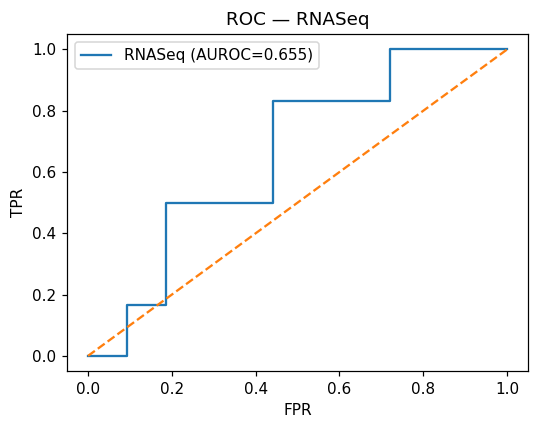

ROC curve saved to: ./results/latent_comparisons/roc_RNASeq.png
[SUCCESS] LoadLatents_Methylation — Found existing PCA embeddings


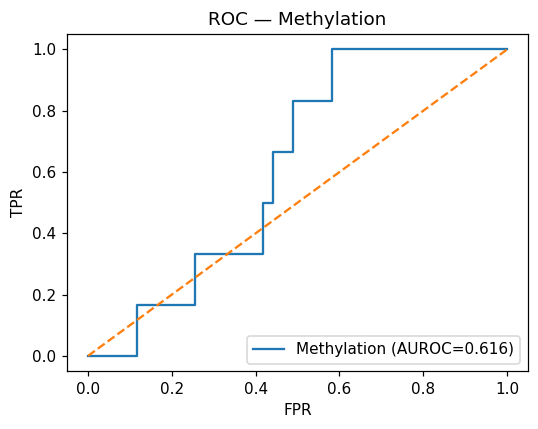

ROC curve saved to: ./results/latent_comparisons/roc_Methylation.png


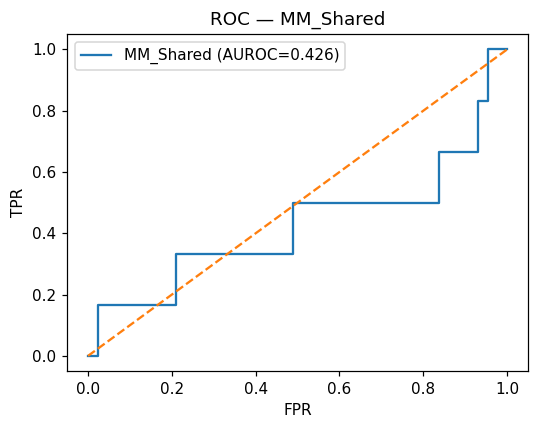

ROC curve saved to: ./results/latent_comparisons/roc_MM_Shared.png


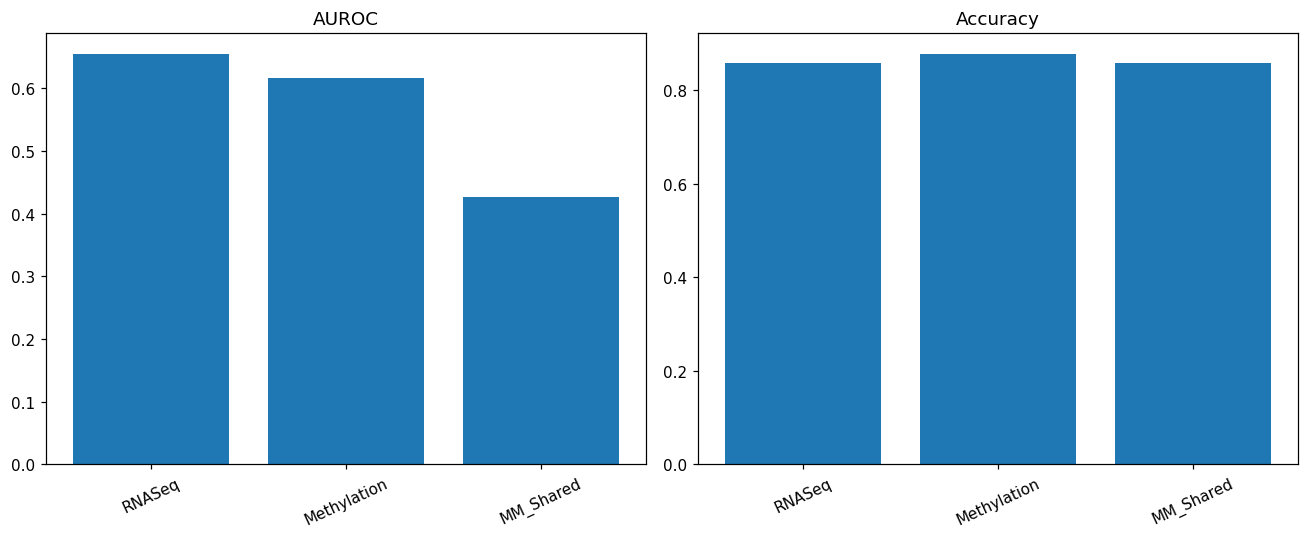

Comparison plot saved to: ./results/latent_comparisons/comparison.png

===== FINAL DOWNSTREAM PERFORMANCE =====

Representation    AUROC       AP  Accuracy
        RNASeq 0.655039 0.202856  0.857143
   Methylation 0.616279 0.170523  0.877551
     MM_Shared 0.426357 0.190931  0.857143


In [171]:
# ===============================================================
# ✅ CELL 6 — Main
# ===============================================================
def main():
    tr_idx, _, te_idx = load_splits()

    # Determine ordering of labels from RNASeq (or clinical fallback)
    rna_df = load_aligned_matrix("rnaseq")
    case_index = (
        rna_df.index.to_list()
        if rna_df is not None else
        pd.read_csv(os.path.join(PROC_DIR, "clinical_aligned.csv"), index_col=0).index.to_list()
    )

    labels = load_clinical_labels(case_index)
    y_train = labels[tr_idx];  y_test = labels[te_idx]

    results = []

    # Evaluate RNA (unimodal)
    rna_train, rna_test = ensure_unimodal_latents("RNASeq")
    if rna_train and rna_test:
        Ztr = pd.read_csv(rna_train).to_numpy()
        Zte = pd.read_csv(rna_test).to_numpy()
        results.append(eval_holdout(Ztr, Zte, y_train, y_test, "RNASeq"))

    # Evaluate DNA methylation (unimodal)
    meth_train, meth_test = ensure_unimodal_latents("Methylation")
    if meth_train and meth_test:
        Ztr = pd.read_csv(meth_train).to_numpy()
        Zte = pd.read_csv(meth_test).to_numpy()
        results.append(eval_holdout(Ztr, Zte, y_train, y_test, "Methylation"))

    # Evaluate Multimodal Shared latent (MM-VAE from 06.py)
    mm_tr, mm_te = load_mm_latents()
    if mm_tr is not None:
        results.append(eval_holdout(mm_tr, mm_te, y_train, y_test, "MM_Shared"))

    # Save results table
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(OUTDIR, "comparison.csv"), index=False)

    # Plot bar comparison
    if not df.empty:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        x = np.arange(len(df))

        ax[0].bar(x, df["AUROC"])
        ax[0].set_xticks(x); ax[0].set_xticklabels(df["Representation"], rotation=25)
        ax[0].set_title("AUROC")

        ax[1].bar(x, df["Accuracy"])
        ax[1].set_xticks(x); ax[1].set_xticklabels(df["Representation"], rotation=25)
        ax[1].set_title("Accuracy")

        plt.tight_layout()
        save_path = os.path.join(OUTDIR, "comparison.png")
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

        plt.show()     # <-- NEW
        plt.close()

        print(f"Comparison plot saved to: {save_path}")


    print("\n===== FINAL DOWNSTREAM PERFORMANCE =====\n")
    print(df.to_string(index=False))


if __name__ == "__main__":
    main()


## RandomForestClassifier model to predit cancer stage

In [ ]:
# ==============================================================
# Cell X — Stage Prediction using RNA, Methylation & Combined PCA
# ==============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

# -----------------------------
# Helper function
# -----------------------------
def evaluate_stage_prediction(X, y, name):
    """
    Train classifier on PCA embeddings and print weighted F1.
    """
    # Remove rows with missing stage
    mask = y.notna()
    X = X[mask]
    y = y[mask]

    # Encode stage labels
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Random Forest (balanced for class imbalance)
    clf = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Weighted F1 Score
    f1 = f1_score(y_test, y_pred, average="weighted")

    print(f"\n===== {name} =====")
    print("Weighted F1:", round(f1, 4))
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return f1

# -----------------------------
# Load PCA embeddings
# -----------------------------
rna_emb = np.load("results/pca_embeddings/rna_pca.npy")
meth_emb = np.load("results/pca_embeddings/methylation_pca.npy")

print("RNA embedding shape:", rna_emb.shape)
print("Methylation embedding shape:", meth_emb.shape)

# Combined multimodal embedding
multi_emb = np.concatenate([rna_emb, meth_emb], axis=1)
print("Multimodal embedding shape:", multi_emb.shape)

# -----------------------------
# Load clinical labels
# -----------------------------
clinical = pd.read_csv("clinical_data_upgraded.csv")

# Use the best available stage column
if "stage_filled" in clinical.columns:
    y = clinical["stage_filled"]
elif "stage_best" in clinical.columns:
    y = clinical["stage_best"]
else:
    raise ValueError("Clinical dataset missing stage_filled / stage_best fields.")

print("Total samples with stage labels:", y.notna().sum())

# -----------------------------
# Run predictions
# -----------------------------
results = {}
results["RNA PCA"] = evaluate_stage_prediction(rna_emb, y, "RNA PCA")
results["Methylation PCA"] = evaluate_stage_prediction(meth_emb, y, "Methylation PCA")
results["Multimodal PCA (RNA + Meth)"] = evaluate_stage_prediction(multi_emb, y, "Multimodal Fusion")

# -----------------------------
# Summary
# -----------------------------
print("\n===== Summary of F1 Scores =====")
for modality, score in results.items():
    print(f"{modality}: {round(score, 4)}")